In [1]:
import osmnx as ox
import networkx as nx
from networkx import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from osmnx import settings

# Erweitere Tags für detaillierte Radweg-Erkennung
settings.useful_tags_way += ["sidewalk", "cycleway", "bicycle", "cycleway:both", "cycleway:left", "cycleway:right", "bicycle_road", "cyclestreet" ]

In [3]:
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

import time

from itertools import chain 
# from scipy.stats import norm
# from scipy.stats import pearsonr

# Daten holen

## Drive

In [4]:
# Straßennetz für einen bestimmten Ort herunterladen
G = ox.graph_from_place("Hagen Mitte, Germany", network_type="drive")

nodes, edges = ox.graph_to_gdfs(G)

# Anzahl der Knoten
print("Anzahl der Knoten:", G.number_of_nodes())
# Anzahl der Kanten
print("Anzahl der Kanten:", G.number_of_edges())
print(f"Komponenten: {nx.number_weakly_connected_components(G)}")
print(f"Komponenten: {nx.number_strongly_connected_components(G)}")

ox.save_graphml(G, filepath='Masterarbeit/Motorised.graphml')

Anzahl der Knoten: 1204
Anzahl der Kanten: 2916
Komponenten: 1
Komponenten: 20


In [4]:
# Ermitteln Sie die geografische Ausdehnung
min_lat = nodes.geometry.y.min()
max_lat = nodes.geometry.y.max()
min_lon = nodes.geometry.x.min()
max_lon = nodes.geometry.x.max()

print(f"Geografische Ausdehnung: ({min_lat}, {min_lon}) bis ({max_lat}, {max_lon})")


Geografische Ausdehnung: (51.3449985, 7.4395889) bis (51.3840042, 7.5369844)


In [18]:
# Schwache Zusammenhangskomponenten identifizieren
components = list(nx.weakly_connected_components(G))

# Komponenten nach Größe sortieren
components_sorted = sorted(components, key=len, reverse=True)

# Die vier größten Komponenten extrahieren und als separate Graphen speichern
one = G.subgraph(components_sorted[0]).copy()
two = G.subgraph(components_sorted[1]).copy()

# Konvertiere die Subgraphen zu GeoDataFrames
one_nodes, one_edges = ox.graph_to_gdfs(one)

# Restliche Komponenten in einem separaten Graph zusammenfassen (optional)
remaining_nodes = set(G.nodes) - set.union(components_sorted[0], components_sorted[1])
remaining_graph = G.subgraph(remaining_nodes).copy()

# Beispiel: Ausgabe der Größen der Subgraphen
print(f"Subgraph one: {len(one_nodes)} Knoten, {len(one_edges)} Kanten")


Subgraph one: 1204 Knoten, 2916 Kanten


In [5]:
# Durchschnittliche Kantenlänge berechnen
mean_length = edges["length"].mean()
print(mean_length)

109.62202434842249


## Bike

In [5]:
B = ox.graph_from_place("Hagen Mitte, Germany", network_type="bike")
nodes, edges = ox.graph_to_gdfs(B)

ox.save_graphml(B, filepath='Masterarbeit/Bike.graphml')

print("Anzahl der Knoten:", B.number_of_nodes())
print("Anzahl der Kanten:", B.number_of_edges())
print(f"Komponenten: {nx.number_weakly_connected_components(B)}") 
print(f"Komponenten: {nx.number_strongly_connected_components(B)}") 

Anzahl der Knoten: 4275
Anzahl der Kanten: 9958
Komponenten: 1
Komponenten: 12


In [43]:
# Ermitteln Sie die geografische Ausdehnung
min_lat = nodes.geometry.y.min()
max_lat = nodes.geometry.y.max()
min_lon = nodes.geometry.x.min()
max_lon = nodes.geometry.x.max()

print(f"Geografische Ausdehnung: ({min_lat}, {min_lon}) bis ({max_lat}, {max_lon})")

Geografische Ausdehnung: (51.3283661, 7.4377301) bis (51.384102, 7.5369844)


In [7]:
# Durchschnittliche Kantenlänge berechnen
mean_length = edges["length"].mean()
print(mean_length)

63.07578067885117


### Stats

In [5]:
from matplotlib.table import Table

# Kanten (Edges) in DataFrame konvertieren
edges = ox.graph_to_gdfs(B, nodes=False)

# maxspeed und bicycle-Tags extrahieren
edges["maxspeed"] = edges["maxspeed"].apply(lambda x: x[0] if isinstance(x, list) else x)

# Neue Spalte für alle relevanten bicycle-Tags erstellen
bicycle_tags = ['yes', 'designated', 'use_sidepath', 'optional_sidepath']
edges["bicycle_allowed"] = edges["bicycle"].apply(
    lambda x: x in bicycle_tags if isinstance(x, str) else False
)

# Häufigkeit der maxspeed-Werte zählen
speed_counts = edges["maxspeed"].value_counts().reset_index()
speed_counts.columns = ["maxspeed", "count"]

# Anzahl der bicycle-erlaubten Straßen pro maxspeed zählen
bike_counts = edges.groupby("maxspeed")["bicycle_allowed"].sum().reset_index()
bike_counts.columns = ["maxspeed", "bicycle_allowed_count"]

# Beide Tabellen mergen
result = pd.merge(speed_counts, bike_counts, on="maxspeed", how="left").fillna(0)
result["bicycle_allowed_count"] = result["bicycle_allowed_count"].astype(int)

# Sortieren nach maxspeed (numerisch)
result["maxspeed_numeric"] = result["maxspeed"].apply(
    lambda x: int(x) if str(x).isdigit() else float('inf')
)
result = result.sort_values("maxspeed_numeric").drop("maxspeed_numeric", axis=1)

# Tabelle als PNG speichern
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis("off")
table = Table(ax, bbox=[0, 0, 1, 1])

# Spalten und Daten hinzufügen
cols = ["maxspeed", "Anzahl Straßen", "Davon für Fahrräder erlaubt"]
cell_text = result.values.tolist()

# Tabellenkopf
table.add_cell(0, 0, width=0.2, height=0.2, text=cols[0], loc="center", facecolor="lightgray")
table.add_cell(0, 1, width=0.2, height=0.2, text=cols[1], loc="center", facecolor="lightgray")
table.add_cell(0, 2, width=0.2, height=0.2, text=cols[2], loc="center", facecolor="lightgray")

# Tabelleninhalt
for i in range(len(cell_text)):
    for j in range(3):
        table.add_cell(i+1, j, width=0.2, height=0.2, 
                      text=str(cell_text[i][j]), loc="center")

ax.add_table(table)
plt.savefig("Masterarbeit/maxspeed_bicycle_stats_extended.png", dpi=300, bbox_inches="tight")
plt.close()

print("Ergebnis wurde als 'maxspeed_bicycle_stats_extended.png' gespeichert.")
result  # Zur Anzeige in der Konsole


Ergebnis wurde als 'maxspeed_bicycle_stats_extended.png' gespeichert.


maxspeed  count  bicycle_allowed_count
7         6     13                      0
2         7    130                      6
4        10     18                      0
6        15     14                      0
3        20     48                      0
0        30   2817                    159
8        40      1                      0
1        50   1312                     96
9        60      1                      0
5        70     16                      0
10       80      1                      0

In [15]:
from matplotlib.table import Table
B = ox.graph_from_place("Hagen Mitte, Germany", network_type="bike")

# Convert edges in the graph to a DataFrame
edges = ox.graph_to_gdfs(B, nodes=False)

edges["highway"] = edges["highway"].apply(lambda x: x[0] if isinstance(x, list) else x)

# Extract relevant bicycle tags
bicycle_tags = ['yes']
edges["bicycle_allowed"] = edges["bicycle"].apply(
    lambda x: x in bicycle_tags if isinstance(x, str) else False
)

# Count the frequency of highway values
highway_counts = edges["highway"].value_counts().reset_index()
highway_counts.columns = ["highway", "count"]

# Count the number of bicycle-allowed streets per highway type
bike_counts = edges.groupby("highway")["bicycle_allowed"].sum().reset_index()
bike_counts.columns = ["highway", "bicycle_allowed_count"]

# Merge both tables
result = pd.merge(highway_counts, bike_counts, on="highway", how="left").fillna(0)
result["bicycle_allowed_count"] = result["bicycle_allowed_count"].astype(int)

# Sort alphabetically by highway type
result = result.sort_values("highway")

# Save table as PNG
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis("off")
table = Table(ax, bbox=[0, 0, 1, 1])

# Columns and data for the table
cols = ["highway", "Anzahl Straßen", "Davon für Fahrräder erlaubt"]
cell_text = result.values.tolist()

# Add table header
table.add_cell(0, 0, width=0.2, height=0.2, text=cols[0], loc="center", facecolor="lightgray")
table.add_cell(0, 1, width=0.2, height=0.2, text=cols[1], loc="center", facecolor="lightgray")
table.add_cell(0, 2, width=0.2, height=0.2, text=cols[2], loc="center", facecolor="lightgray")

# Add table content
for i in range(len(cell_text)):
    for j in range(3):
        table.add_cell(i+1, j, width=0.2, height=0.2,
                       text=str(cell_text[i][j]), loc="center")

ax.add_table(table)
plt.savefig("Masterarbeit/highway_bicycle_stats_extended.png", dpi=300, bbox_inches="tight")
plt.close()

print("Ergebnis wurde als 'highway_bicycle_stats_extended.png' gespeichert.")
result  # Display in console


Ergebnis wurde als 'highway_bicycle_stats_extended.png' gespeichert.


highway  count  bicycle_allowed_count
10        cycleway      7                      0
6    living_street    331                     22
2             path   1258                    187
9       pedestrian     48                     30
7          primary    312                      3
15    primary_link      3                      0
1      residential   2955                    137
3        secondary    458                      9
12  secondary_link      6                      0
0          service   3597                     33
4         tertiary    438                     12
13   tertiary_link      6                      0
5            track    358                     12
14           trunk      4                      0
11      trunk_link      6                      0
8     unclassified    171                      6

In [50]:
# Kanten (Edges) aus dem Graphen extrahieren
edges = ox.graph_to_gdfs(B, nodes=False)

# Filtern nach trunk und trunk_link
trunk_edges = edges[edges["highway"].isin(["trunk", "trunk_link"])].copy()

# Alle verfügbaren Spalten anzeigen (falls gewünscht)
print("Verfügbare Spalten im DataFrame:")
print(trunk_edges.columns.tolist())  # Optional: Zeigt alle Attribute

# Alle relevanten Daten anzeigen (komplett oder mit ausgewählten Spalten)
pd.set_option('display.max_columns', None)  # Alle Spalten anzeigen
pd.set_option('display.expand_frame_repr', False)  # Kein Zeilenumbruch

# print("\nDetaillierte Informationen für trunk/trunk_link-Kanten:")
# print(trunk_edges)

relevant_columns = [
    "highway", "maxspeed", "bicycle", "lanes", "name", 
    "oneway", "length"
]
print("\nWichtige Attribute für trunk/trunk_link:")
print(trunk_edges[relevant_columns])


Verfügbare Spalten im DataFrame:
['osmid', 'lanes', 'ref', 'name', 'highway', 'maxspeed', 'oneway', 'reversed', 'length', 'geometry', 'bridge', 'access', 'bicycle', 'service', 'cycleway:left', 'cycleway:right', 'cycleway', 'cycleway:both', 'width', 'junction', 'tunnel', 'est_width', 'bicycle_road', 'area']

Wichtige Attribute für trunk/trunk_link:
                              highway  maxspeed bicycle   lanes                             name  oneway    length
u          v          key                                                                                         
21554814   21554765   0    trunk_link        50     NaN       1                              NaN    True    25.810
           1468116628 0    trunk_link        50     NaN       1                              NaN    True    50.254
348006856  867968429  0    trunk_link       NaN     NaN       1                              NaN    True    36.402
867968429  1468106037 0    trunk_link       NaN     NaN       1            

In [45]:
# Graph laden
B_filtered = ox.graph_from_place("Hagen Mitte, Germany", network_type="bike")

print("Anzahl der Knoten:", B_filtered.number_of_nodes())
print("Anzahl der Kanten:", B_filtered.number_of_edges())
print(f"Komponenten: {nx.number_weakly_connected_components(B_filtered)}")
print(f"Komponenten: {nx.number_strongly_connected_components(B_filtered)}")

# Größte zusammenhängende Komponente extrahieren
largest_cc = max(nx.weakly_connected_components(B_filtered), key=len)
B_main = B_filtered.subgraph(largest_cc).copy()
print("Anzahl der Knoten größte Komponente:", B_main.number_of_nodes())
print("Anzahl der Kanten größte Komponente:", B_main.number_of_edges())

# Kanten mit maxspeed 60/70/80 ODER highway=trunk/trunk_link identifizieren und entfernen
edges_to_remove = []
for u, v, k, data in B_filtered.edges(keys=True, data=True):
    remove_edge = False
    
    # maxspeed
    if 'maxspeed' in data:
        maxspeed = data['maxspeed']
        if isinstance(maxspeed, list):  # Falls Liste, erstes Element nehmen
            maxspeed = maxspeed[0]
        maxspeed = str(maxspeed)  # Als String vergleichen
        if maxspeed in ['60', '70', '80']:
            remove_edge = True
    
    # highway=trunk, trunk_link (Schnellstraßen), bridleway (Reitwege)
    if 'highway' in data and data['highway'] in ['trunk', 'trunk_link']:
        remove_edge = True
    
    # Zur Löschliste hinzufügen
    if remove_edge:
        edges_to_remove.append((u, v, k))

# Kanten entfernen
B_filtered.remove_edges_from(edges_to_remove)

print("------------------------------")
print("Nach Filterung:")
print(f"{len(edges_to_remove)} Kanten entfernt (maxspeed 60/70/80 oder trunk/trunk_link).")

print("Anzahl der Knoten:", B_filtered.number_of_nodes())
print(f"Anzahl der Kanten:", B_filtered.number_of_edges())
print(f"Komponenten: {nx.number_weakly_connected_components(B_filtered)}")
print(f"Komponenten: {nx.number_strongly_connected_components(B_filtered)}")

# Größte zusammenhängende Komponente extrahieren
largest_cc = max(nx.weakly_connected_components(B_filtered), key=len)
B_filtered_main = B_filtered.subgraph(largest_cc).copy()
print("Anzahl der Knoten größte Komponente:", B_filtered_main.number_of_nodes())
print("Anzahl der Kanten größte Komponente:", B_filtered_main.number_of_edges())

ox.save_graphml(B_filtered_main, filepath='Masterarbeit/Bike_filtered_main.graphml')

Anzahl der Knoten: 4275
Anzahl der Kanten: 9958
Komponenten: 1
Komponenten: 12
Anzahl der Knoten größte Komponente: 4275
Anzahl der Kanten größte Komponente: 9958
------------------------------
Nach Filterung:
26 Kanten entfernt (maxspeed 60/70/80 oder trunk/trunk_link).
Anzahl der Knoten: 4275
Anzahl der Kanten: 9932
Komponenten: 10
Komponenten: 19
Anzahl der Knoten größte Komponente: 4264
Anzahl der Kanten größte Komponente: 9928


In [6]:
# Berechnung der verbleibenden Prozente
remaining_nodes_percent = (len(B_filtered_main.nodes) / len(B.nodes)) * 100
remaining_edges_percent = (len(B_filtered_main.edges) / len(B.edges)) * 100

# Berechnung der entfernten Prozente
removed_nodes_percent = 100 - remaining_nodes_percent
removed_edges_percent = 100 - remaining_edges_percent

# Ausgabe der Ergebnisse
print(f"Verbleibende Knoten: {remaining_nodes_percent:.1f}%")
print(f"Entfernte Knoten: {removed_nodes_percent:.1f}%")
print(f"Verbleibende Kanten: {remaining_edges_percent:.1f}%")
print(f"Entfernte Kanten: {removed_edges_percent:.1f}%")


Verbleibende Knoten: 99.7%
Entfernte Knoten: 0.3%
Verbleibende Kanten: 99.7%
Entfernte Kanten: 0.3%


In [5]:
from matplotlib.table import Table

# Graph laden
B = ox.graph_from_place("Hagen Mitte, Germany", network_type="bike")
edges = ox.graph_to_gdfs(B, nodes=False)

# Liste der zu analysierenden Attribute
attributes = [
    'cycleway:both',
    'cycleway',
    'cycleway:right', 
    'cycleway:left',
    'bicycle',
    'bicycle_road'
]

# Funktion zur Erstellung der Tabellenbilder
def create_attribute_table(attr_name, edges):
    # Werte zählen (mit 'None' für fehlende Werte)
    counts = edges[attr_name].fillna('(fehlt)').value_counts().reset_index()
    counts.columns = [attr_name, "Anzahl"]
    
    # Sortieren nach Anzahl (absteigend)
    counts = counts.sort_values("Anzahl", ascending=False)
    
    # Tabellenbild erstellen
    fig, ax = plt.subplots(figsize=(12, max(4, len(counts)//2)))
    ax.axis("off")
    table = Table(ax, bbox=[0, 0, 1, 1])
    
    # Tabellenkopf
    table.add_cell(0, 0, width=0.3, height=0.1, 
                  text=attr_name, loc="center", facecolor="lightgray")
    table.add_cell(0, 1, width=0.3, height=0.1, 
                  text="Anzahl", loc="center", facecolor="lightgray")
    
    # Tabelleninhalt
    for i, row in counts.iterrows():
        table.add_cell(i+1, 0, width=0.3, height=0.1, 
                      text=str(row[attr_name]), loc="center")
        table.add_cell(i+1, 1, width=0.3, height=0.1, 
                      text=str(row["Anzahl"]), loc="center")
    
    ax.add_table(table)
    plt.savefig(f"Masterarbeit/{attr_name}_stats.png", dpi=300, bbox_inches="tight")
    plt.close()
    
    return counts

# Analyse für jedes Attribut durchführen
results = {}
for attr in attributes:
    try:
        results[attr] = create_attribute_table(attr, edges)
        print(f"Tabelle für {attr} erstellt")
    except Exception as e:
        print(f"Fehler bei {attr}: {str(e)}")

# Ergebnisse auch als Excel exportieren
# with pd.ExcelWriter('Masterarbeit/radinfrastruktur_stats.xlsx') as writer:
#     for attr, df in results.items():
#         df.to_excel(writer, sheet_name=attr[:31], index=False)

print("\nAlle Tabellen wurden erstellt und als PNG/Excel gespeichert.")
results

Tabelle für cycleway:both erstellt
Tabelle für cycleway erstellt
Tabelle für cycleway:right erstellt
Tabelle für cycleway:left erstellt
Tabelle für bicycle erstellt
Tabelle für bicycle_road erstellt

Alle Tabellen wurden erstellt und als PNG/Excel gespeichert.


{'cycleway:both':   cycleway:both  Anzahl
 0       (fehlt)    9518
 1            no     432
 2         track       8,
 'cycleway':                 cycleway  Anzahl
 0                (fehlt)    9766
 1                     no      89
 2           share_busway      37
 3               separate      22
 4                   lane      21
 5                   both       8
 6                  track       6
 7               opposite       3
 8                 shared       2
 9               sidewalk       2
 10        opposite_track       1
 11  [share_busway, lane]       1,
 'cycleway:right':   cycleway:right  Anzahl
 0        (fehlt)    9740
 1             no     146
 2           lane      32
 3       separate      16
 4    shared_lane      13
 5          track       8
 6     [lane, no]       2
 7    [track, no]       1,
 'cycleway:left':   cycleway:left  Anzahl
 0       (fehlt)    9779
 1      separate      84
 2            no      41
 3          lane      32
 4         track      22,
 'bicy

In [28]:

# Graph laden
print("Lade Straßennetz für Hagen Mitte...")
B = ox.graph_from_place("Hagen Mitte, Germany", network_type="bike")
edges = ox.graph_to_gdfs(B, nodes=False)

# Liste der zu analysierenden Attribute
attributes = [
    'cycleway:both',
    'cycleway',
    'cycleway:right',
    'cycleway:left',
    'bicycle',
    'bicycle_road'
]

print("\nVorkommende Werte pro Attribut:")
print("="*50)

for attr in attributes:
    print(f"\nAttribut: {attr}")
    print("-"*40)
    
    try:
        # Für Attribute, die Listen enthalten können
        if edges[attr].apply(type).eq(list).any():
            # Explode lists to separate rows
            exploded = edges[attr].dropna().explode()
            unique_values = exploded.unique()
            value_counts = exploded.value_counts()
        else:
            unique_values = edges[attr].dropna().unique()
            value_counts = edges[attr].value_counts()
        
        count_total = edges[attr].notna().sum()
        print(f"Anzahl Kanten mit diesem Attribut: {count_total}/{len(edges)} ({count_total/len(edges):.1%})")
        
        if len(value_counts) > 0:
            for value, count in value_counts.items():
                print(f"• '{value}': {count} Kanten ({count/len(edges):.1%})")
        else:
            print("Keine Werte vorhanden")
            
        print(f"\nEinzigartige Werte: {', '.join(map(str, unique_values)) if len(unique_values) > 0 else 'Keine'}")
        
    except Exception as e:
        print(f"Fehler beim Verarbeiten des Attributs: {str(e)}")
        print("Versuche alternative Methode...")
        
        # Alternative Methode für komplexe Fälle
        unique_values = set()
        for val in edges[attr].dropna():
            if isinstance(val, list):
                unique_values.update(val)
            else:
                unique_values.add(val)
        
        print(f"Einzigartige Werte (alternative Methode): {', '.join(map(str, unique_values)) if unique_values else 'Keine'}")

    print("="*50)

# Zusätzliche Analyse
has_any_cycleway = (
    edges['cycleway:both'].notna() | 
    edges['cycleway'].notna() | 
    edges['cycleway:right'].notna() | 
    edges['cycleway:left'].notna()
).sum()

print(f"\nZusammenfassung:")
print(f"Kanten mit mindestens einem cycleway-Tag: {has_any_cycleway}/{len(edges)} ({has_any_cycleway/len(edges):.1%})")


Lade Straßennetz für Hagen Mitte...

Vorkommende Werte pro Attribut:

Attribut: cycleway:both
----------------------------------------
Anzahl Kanten mit diesem Attribut: 440/9958 (4.4%)
• 'no': 432 Kanten (4.3%)
• 'track': 8 Kanten (0.1%)

Einzigartige Werte: no, track

Attribut: cycleway
----------------------------------------
Anzahl Kanten mit diesem Attribut: 192/9958 (1.9%)
• 'no': 89 Kanten (0.9%)
• 'share_busway': 38 Kanten (0.4%)
• 'lane': 22 Kanten (0.2%)
• 'separate': 22 Kanten (0.2%)
• 'both': 8 Kanten (0.1%)
• 'track': 6 Kanten (0.1%)
• 'opposite': 3 Kanten (0.0%)
• 'shared': 2 Kanten (0.0%)
• 'sidewalk': 2 Kanten (0.0%)
• 'opposite_track': 1 Kanten (0.0%)

Einzigartige Werte: lane, share_busway, no, track, both, opposite, separate, opposite_track, shared, sidewalk

Attribut: cycleway:right
----------------------------------------
Anzahl Kanten mit diesem Attribut: 218/9958 (2.2%)
• 'no': 149 Kanten (1.5%)
• 'lane': 34 Kanten (0.3%)
• 'separate': 16 Kanten (0.2%)
• 'shared_

## Bicycle

In [26]:

custom_filter = (
    '["bicycle"~"yes|designated|use_sidepath|optional_sidepath"]'  # Fahrradweg oder erlaubt
)

Z = ox.graph_from_place(
    "Hagen Mitte, Germany", 
    custom_filter=custom_filter,
    retain_all=True
)
nodes, edges = ox.graph_to_gdfs(Z)

ox.save_graphml(Z, filepath='Masterarbeit/Bicycle.graphml')

# Anzahl der Knoten
print("Anzahl der Knoten:", Z.number_of_nodes())

# Anzahl der Kanten
print("Anzahl der Kanten:", Z.number_of_edges())

Anzahl der Knoten: 350
Anzahl der Kanten: 551


## Bicycle and slow (Bikeable)

In [16]:
# Hilfsfunktion zur Ausgabe der Graph-Statistiken
def print_stats(graph, beschreibung):
    print(f"{beschreibung}")
    print("Anzahl der Knoten:", graph.number_of_nodes())
    print("Anzahl der Kanten:", graph.number_of_edges(), "\n")

# 1. Fahrrad-Infrastruktur
bike_filter = '["bicycle"~"yes|designated|use_sidepath|optional_sidepath"]'
G_bike = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=bike_filter, retain_all=True)
print_stats(G_bike, "Fahrrad-Infrastruktur:")   

# 2. Langsame Straßen
slow_filter = '["maxspeed"~"^(30|20|10|7|6)$"]["access"!~"private|no"]["highway"!~"motorway|motorway_link|trunk|trunk_link"]'
G_slow = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=slow_filter, retain_all=True)
print_stats(G_slow, "Langsame Straßen:")

# 3. Fußwege und zugängliche Straßen
foot_filter = '["highway"~"path|track|living_street"]["access"!~"private|no"]'
G_foot = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=foot_filter, retain_all=True)
print_stats(G_foot, "Fußwege:")

# 4. Schnelle Straßen
fast_filter = '["maxspeed"~"^(40|50|60|70|80)$"]["access"!~"private|no"]'
G_fast = ox.graph_from_place("Hagen Mitte, Germany", network_type="bike", custom_filter=fast_filter, retain_all=True)
print_stats(G_fast, "schnelle Straßen:")

# 5. Schnellstraßen
trunk_filter = '["highway"~"trunk|trunk_link"]'
G_trunk = ox.graph_from_place("Hagen Mitte, Germany", network_type="bike", custom_filter=trunk_filter, retain_all=True)
print_stats(G_trunk, "schnelle Straßen:")

# Kombinationen
E = nx.compose_all([G_bike, G_slow])
Fast = nx.compose_all([G_fast, G_trunk])

print_stats(Fast, "Gesamtkombination aller Graphen:")


Fahrrad-Infrastruktur:
Anzahl der Knoten: 350
Anzahl der Kanten: 551 

Langsame Straßen:
Anzahl der Knoten: 817
Anzahl der Kanten: 1707 

Fußwege:
Anzahl der Knoten: 955
Anzahl der Kanten: 1667 

schnelle Straßen:
Anzahl der Knoten: 282
Anzahl der Kanten: 493 

schnelle Straßen:
Anzahl der Knoten: 12
Anzahl der Kanten: 10 

Gesamtkombination aller Graphen:
Anzahl der Knoten: 288
Anzahl der Kanten: 499 



## Cycleway_combined

In [5]:
# Hilfsfunktion zur Ausgabe der Graph-Statistiken
def print_stats(graph, beschreibung):
    print(f"{beschreibung}")
    print("Anzahl der Knoten:", graph.number_of_nodes())
    print("Anzahl der Kanten:", graph.number_of_edges(), "\n")

bike_filter = '["bicycle"~"yes|designated|use_sidepath|optional_sidepath"]'
G_bike = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=bike_filter, retain_all=True)
print_stats(G_bike, "bicycle-Infrastruktur:")

bicycle_designated_filter = '["bicycle"~"designated|use_sidepath|optional_sidepath"]'
G_bicycle_designated = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=bicycle_designated_filter, retain_all=True)
print_stats(G_bicycle_designated, "bicycle:designated-Infrastruktur:")

bicycle_yes_filter = '["bicycle"~"yes"]["highway"!~"trunk|trunk_link|primary|primary_link|secondary|secondary_link|tertiary|tertiary_link|residential|service"]'
G_bicycle_yes = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=bicycle_yes_filter, retain_all=True)
print_stats(G_bicycle_yes, "bicycle:yes-Infrastruktur:")

cycleway_both_filter = '["cycleway:both"~"track"]'
G_cycleway_both = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=cycleway_both_filter, retain_all=True)
print_stats(G_cycleway_both, "cycleway:both-Infrastruktur:")

cycleway_filter = '["cycleway"~"lane|share_busway|track|both|opposite|separate|opposite_track|shared|sidewalk"]'
G_cycleway = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=cycleway_filter, retain_all=True)
print_stats(G_cycleway, "cycleway-Infrastruktur:")

cycleway_left_filter = '["cycleway:left"~"lane|track|shared_lane|separate"]'
G_cycleway_left = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=cycleway_left_filter, retain_all=True)
print_stats(G_cycleway_both, "cycleway:left-Infrastruktur:")

cycleway_right_filter = '["cycleway:right"~"lane|track|shared_lane|separate"]'
G_cycleway_right = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=cycleway_right_filter, retain_all=True)
print_stats(G_cycleway_right, "cycleway:right-Infrastruktur:")

bicycle_road_filter = '["bicycle_road"~"yes"]'
G_bicycle_road = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=bicycle_road_filter, retain_all=True)
print_stats(G_bicycle_road, "bicycle_road-Infrastruktur:")

highway_cycleway_filter = '["highway"~"cycleway"]'
G_highway_cycleway = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=highway_cycleway_filter, retain_all=True)
print_stats(G_highway_cycleway, "highway_cycleway-Infrastruktur:")

# Kombinationen
Cycleway_combined = nx.compose_all([G_bike, G_cycleway_both, G_cycleway, G_cycleway_left, G_cycleway_right, G_bicycle_road, G_highway_cycleway])
print_stats(Cycleway_combined, "Gesamtkombination aller Graphen:")

Cycleway_combined_filtered = nx.compose_all([G_bicycle_designated, G_bicycle_yes, G_cycleway_both, G_cycleway, G_cycleway_left, G_cycleway_right, G_bicycle_road, G_highway_cycleway])
print_stats(Cycleway_combined_filtered, "Gesamtkombination aller Graphen:")

# 2. Langsame Straßen
slow_filter = '["maxspeed"~"^(30|20|10|7|6)$"]["access"!~"private|no"]["highway"!~"motorway|motorway_link|trunk|trunk_link"]'
G_slow = ox.graph_from_place("Hagen Mitte, Germany", custom_filter=slow_filter, retain_all=True)
print_stats(G_slow, "Langsame Straßen:")

bicycle-Infrastruktur:
Anzahl der Knoten: 350
Anzahl der Kanten: 551 

bicycle:designated-Infrastruktur:
Anzahl der Knoten: 148
Anzahl der Kanten: 235 

bicycle:yes-Infrastruktur:
Anzahl der Knoten: 160
Anzahl der Kanten: 206 

cycleway:both-Infrastruktur:
Anzahl der Knoten: 4
Anzahl der Kanten: 4 

cycleway-Infrastruktur:
Anzahl der Knoten: 35
Anzahl der Kanten: 31 

cycleway:left-Infrastruktur:
Anzahl der Knoten: 4
Anzahl der Kanten: 4 

cycleway:right-Infrastruktur:
Anzahl der Knoten: 30
Anzahl der Kanten: 25 

bicycle_road-Infrastruktur:
Anzahl der Knoten: 3
Anzahl der Kanten: 3 

highway_cycleway-Infrastruktur:
Anzahl der Knoten: 23
Anzahl der Kanten: 36 

Gesamtkombination aller Graphen:
Anzahl der Knoten: 415
Anzahl der Kanten: 655 

Gesamtkombination aller Graphen:
Anzahl der Knoten: 362
Anzahl der Kanten: 545 

Langsame Straßen:
Anzahl der Knoten: 817
Anzahl der Kanten: 1707 



### Stats

In [8]:
missing_bicycle_count = sum(
    1 for u, v, data in Cycleway_combined.edges(data=True)
    if data.get('bicycle') in [None, '']
)

print(f"{missing_bicycle_count} Kanten haben kein oder ein leeres 'bicycle'-Attribut")


65 Kanten haben kein oder ein leeres 'bicycle'-Attribut


In [12]:
B = ox.graph_from_place("Hagen Mitte, Germany", network_type="bike")
nodes, edges = ox.graph_to_gdfs(B)

# Filter-Definitionen
filters = {
    "bicycle": '["bicycle"~"yes|designated|use_sidepath|optional_sidepath"]',
    "cycleway_both": '["cycleway:both"~"track"]',
    "cycleway": '["cycleway"~"lane|share_busway|track|both|opposite|separate|opposite_track|shared|sidewalk"]',
    "cycleway_left": '["cycleway:left"~"lane|track|shared_lane|separate"]',
    "cycleway_right": '["cycleway:right"~"lane|track|shared_lane|separate"]',
    "bicycle_road": '["bicycle_road"~"yes"]'
}

# 1. Einzelne Filterzählung
results = {}
for name, filter_expr in filters.items():
    # Extrahiere Werte zwischen ~" und "]
    values = filter_expr.split('~"')[1].split('"')[0].split("|")
    key = filter_expr.split('"')[1]  # z.B. "cycleway:left"
    
    count = sum(
        1 for u, v, data in B.edges(data=True)
        if any(str(data.get(key, "")).lower() == v.lower() for v in values)
    )
    results[name] = count

# 2. Gesamtzählung (Kanten die mind. einem Filter entsprechen)
total_matching = sum(
    1 for u, v, data in B.edges(data=True)
    if any([
        # Erster bicycle-Eintrag (als String)
        data.get("bicycle") in ["yes", "designated", "use_sidepath", "optional_sidepath"],
        
        # Originalchecks für andere Felder
        data.get("cycleway:both") == "track",
        data.get("cycleway") in ["lane", "share_busway", "track", "both", "opposite", "separate", "opposite_track", "shared", "sidewalk"],
        data.get("cycleway:left") in ["lane", "track", "shared_lane", "separate"],
        data.get("cycleway:right") in ["lane", "track", "shared_lane", "separate"],
        data.get("bicycle_road") == "yes"
    ])
)



# Ausgabe
print("Einzelne Filter:")
for name, count in results.items():
    print(f"{name}: {count} Kanten")

print(f"\nKanten die mindestens einem Filter entsprechen: {total_matching}")
print(f"Gesamtkanten im Graph: {B.number_of_edges()}")


Einzelne Filter:
bicycle: 915 Kanten
cycleway_both: 8 Kanten
cycleway: 102 Kanten
cycleway_left: 138 Kanten
cycleway_right: 69 Kanten
bicycle_road: 13 Kanten

Kanten die mindestens einem Filter entsprechen: 1187
Gesamtkanten im Graph: 9958


## Bicycle Designated

In [53]:
working_filter = (
    '["bicycle"~"designated|use_sidepath|optional_sidepath"]'
)

T = ox.graph_from_place(
    "Hagen Mitte, Germany",
    custom_filter=working_filter,
    retain_all=True
)
nodes, edges = ox.graph_to_gdfs(T)

ox.save_graphml(T, filepath='Masterarbeit/Bicycle_Designated.graphml')

# Anzahl der Knoten
print("Anzahl der Knoten:", T.number_of_nodes())

# Anzahl der Kanten
print("Anzahl der Kanten:", T.number_of_edges())

Anzahl der Knoten: 148
Anzahl der Kanten: 235


## all

In [10]:
A = ox.graph_from_place("Hagen Mitte, Germany", network_type="all", retain_all=True)
nodes, edges = ox.graph_to_gdfs(A)

ox.save_graphml(A, filepath='Masterarbeit/All.graphml')

# Anzahl der Knoten
print("Anzahl der Knoten:", A.number_of_nodes())
# Anzahl der Kanten
print("Anzahl der Kanten:", A.number_of_edges())

# Berechnung der Anzahl der Komponenten
components_weakly_connected = nx.number_weakly_connected_components(A)
print(f"Der Graph besteht aus {components_weakly_connected} verschiedenen weakly_connected Komponenten.")
print(f"Der Graph besteht aus {nx.number_strongly_connected_components(A)} verschiedenen weakly_connected Komponenten.")

Anzahl der Knoten: 7927
Anzahl der Kanten: 19961
Der Graph besteht aus 61 verschiedenen weakly_connected Komponenten.
Der Graph besteht aus 80 verschiedenen weakly_connected Komponenten.


In [12]:
# Größte zusammenhängende Komponente extrahieren
largest_cc = max(nx.weakly_connected_components(A), key=len)
A_main = A.subgraph(largest_cc).copy()
print("Anzahl der Knoten größte Komponente:", A_main.number_of_nodes())
print("Anzahl der Kanten größte Komponente:", A_main.number_of_edges())

Anzahl der Knoten größte Komponente: 7786
Anzahl der Kanten größte Komponente: 19777


## Gescheiterte Versuche Kombination (Radwege, Fußwege und Straßen mit max. 30 km/h)

In [7]:

custom_filter = (
        '["bicycle"~"yes|designated|use_sidepath|optional_sidepath"]'
        ' ; '
        '["maxspeed"~"^(30|20|10|7|6)$"]'
        '["access"!~"private|no"]'
        '["highway"!~"motorway|motorway_link|steps"]'
        or
        '["highway"~"footway|pedestrian|path|track|living_street"]'
        and
        '["access"!~"private|no"]'
    )


# Einheitlicher Graph mit allen relevanten Wegen
X = ox.graph_from_place(
    "Hagen Mitte, Germany",
    custom_filter=custom_filter,
    retain_all=True,
    simplify=True
)

nodes, edges = ox.graph_to_gdfs(X)

ox.save_graphml(X, filepath='Masterarbeit/Testen.graphml')

# Anzahl der Knoten
print("Anzahl der Knoten:", X.number_of_nodes())
# Anzahl der Kanten
print("Anzahl der Kanten:", X.number_of_edges())

# Prüfe Komponenten
print(f"Komponenten: {nx.number_weakly_connected_components(X)}")  # Sollte 1 sein


ResponseStatusCodeError: 'overpass-api.de' responded: 400 Bad Request <?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN"
    "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">
<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en">
<head>
  <meta http-equiv="content-type" content="text/html; charset=utf-8" lang="en"/>
  <title>OSM3S Response</title>
</head>
<body>

<p>The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.</p>
<p><strong style="color:#FF0000">Error</strong>: line 1: parse error: Unknown type &quot;[&quot; </p>
<p><strong style="color:#FF0000">Error</strong>: line 1: parse error: An empty query is not allowed </p>
<p><strong style="color:#FF0000">Error</strong>: line 1: parse error: ';' expected - '&quot;maxspeed&quot;' found. </p>

</body>
</html>


In [15]:

custom_filter = (
        '["bicycle"!~"no"]'
        '["access"!~"private|no"]'
        '["highway"!~"motorway|motorway_link|steps|trunk|trunk-link|service|corridor|traffic_signals"]'
    )


# Einheitlicher Graph mit allen relevanten Wegen
X = ox.graph_from_place(
    "Hagen Mitte, Germany",
    network_type="bike",
    custom_filter=custom_filter,
    simplify=True
)

nodes, edges = ox.graph_to_gdfs(X)

# Filter: landuse=residential ODER nicht definiert
filtered_edges = edges[
    (edges["landuse"] == "residential") | 
    (edges["landuse"].isna())
]

# Zurück zu einem Graph konvertieren
X_filtered = ox.graph_from_gdfs(nodes, filtered_edges)

# Anzahl der Knoten
print("Anzahl der Knoten:", X_filtered.number_of_nodes())
# Anzahl der Kanten
print("Anzahl der Kanten:", X_filtered.number_of_edges())

# Prüfe Komponenten
print(f"Komponenten: {nx.number_weakly_connected_components(X_filtered)}")  # Sollte 1 sein

ox.save_graphml(X_filtered, filepath='Masterarbeit/Testen.graphml')

Anzahl der Knoten: 16745
Anzahl der Kanten: 55341
Komponenten: 618


# Graphen darstellen

## Karte

### Drive

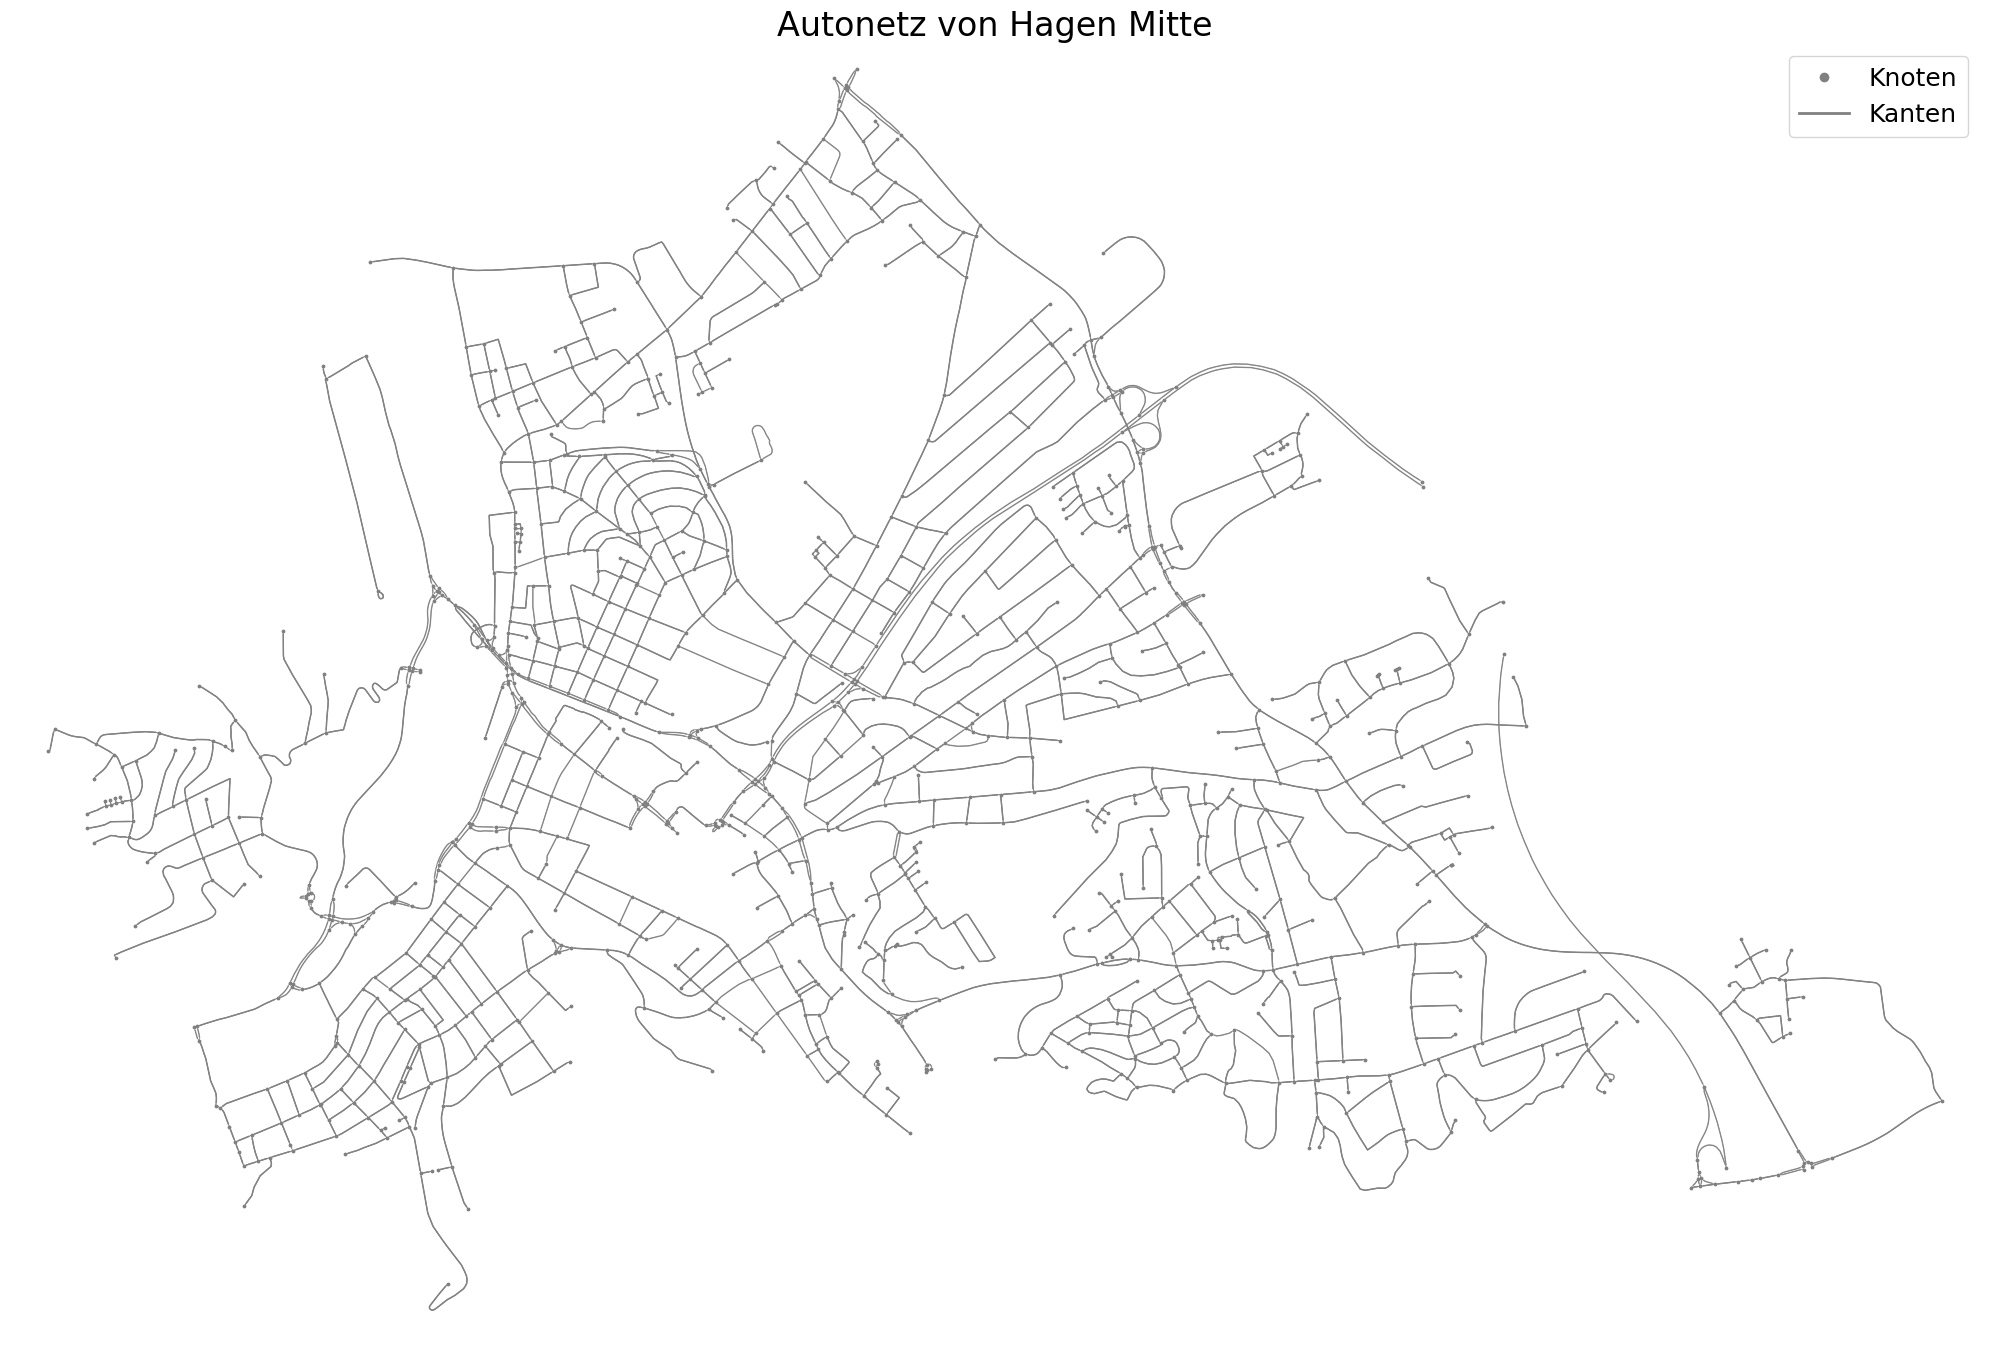

In [8]:
# Straßennetz für einen bestimmten Ort herunterladen
G = ox.graph_from_place("Hagen Mitte, Germany", network_type="drive")
nodes, edges = ox.graph_to_gdfs(G)

fig, ax = ox.plot_graph(G, show=False, close=False, figsize=(20,20), dpi=300)

fig.patch.set_facecolor('white')  # Hintergrund der gesamten Figur weiß
ax.set_facecolor('white') 

nodes.plot(ax=ax, color='grey', markersize=3, alpha=1)
edges.plot(ax=ax, color='grey', linewidth=0.5, alpha=1)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Knoten',
                   markerfacecolor='grey', markersize=8),
                   Line2D([0], [0], color='grey', lw=2, label='Kanten')]
ax.legend(handles=legend_elements, loc='upper right', fontsize=18)

ax.set_title("Autonetz von Hagen Mitte", fontsize=24)

plt.tight_layout()
plt.savefig('Masterarbeit/Autonetz.png', dpi=300, bbox_inches='tight')
plt.show()

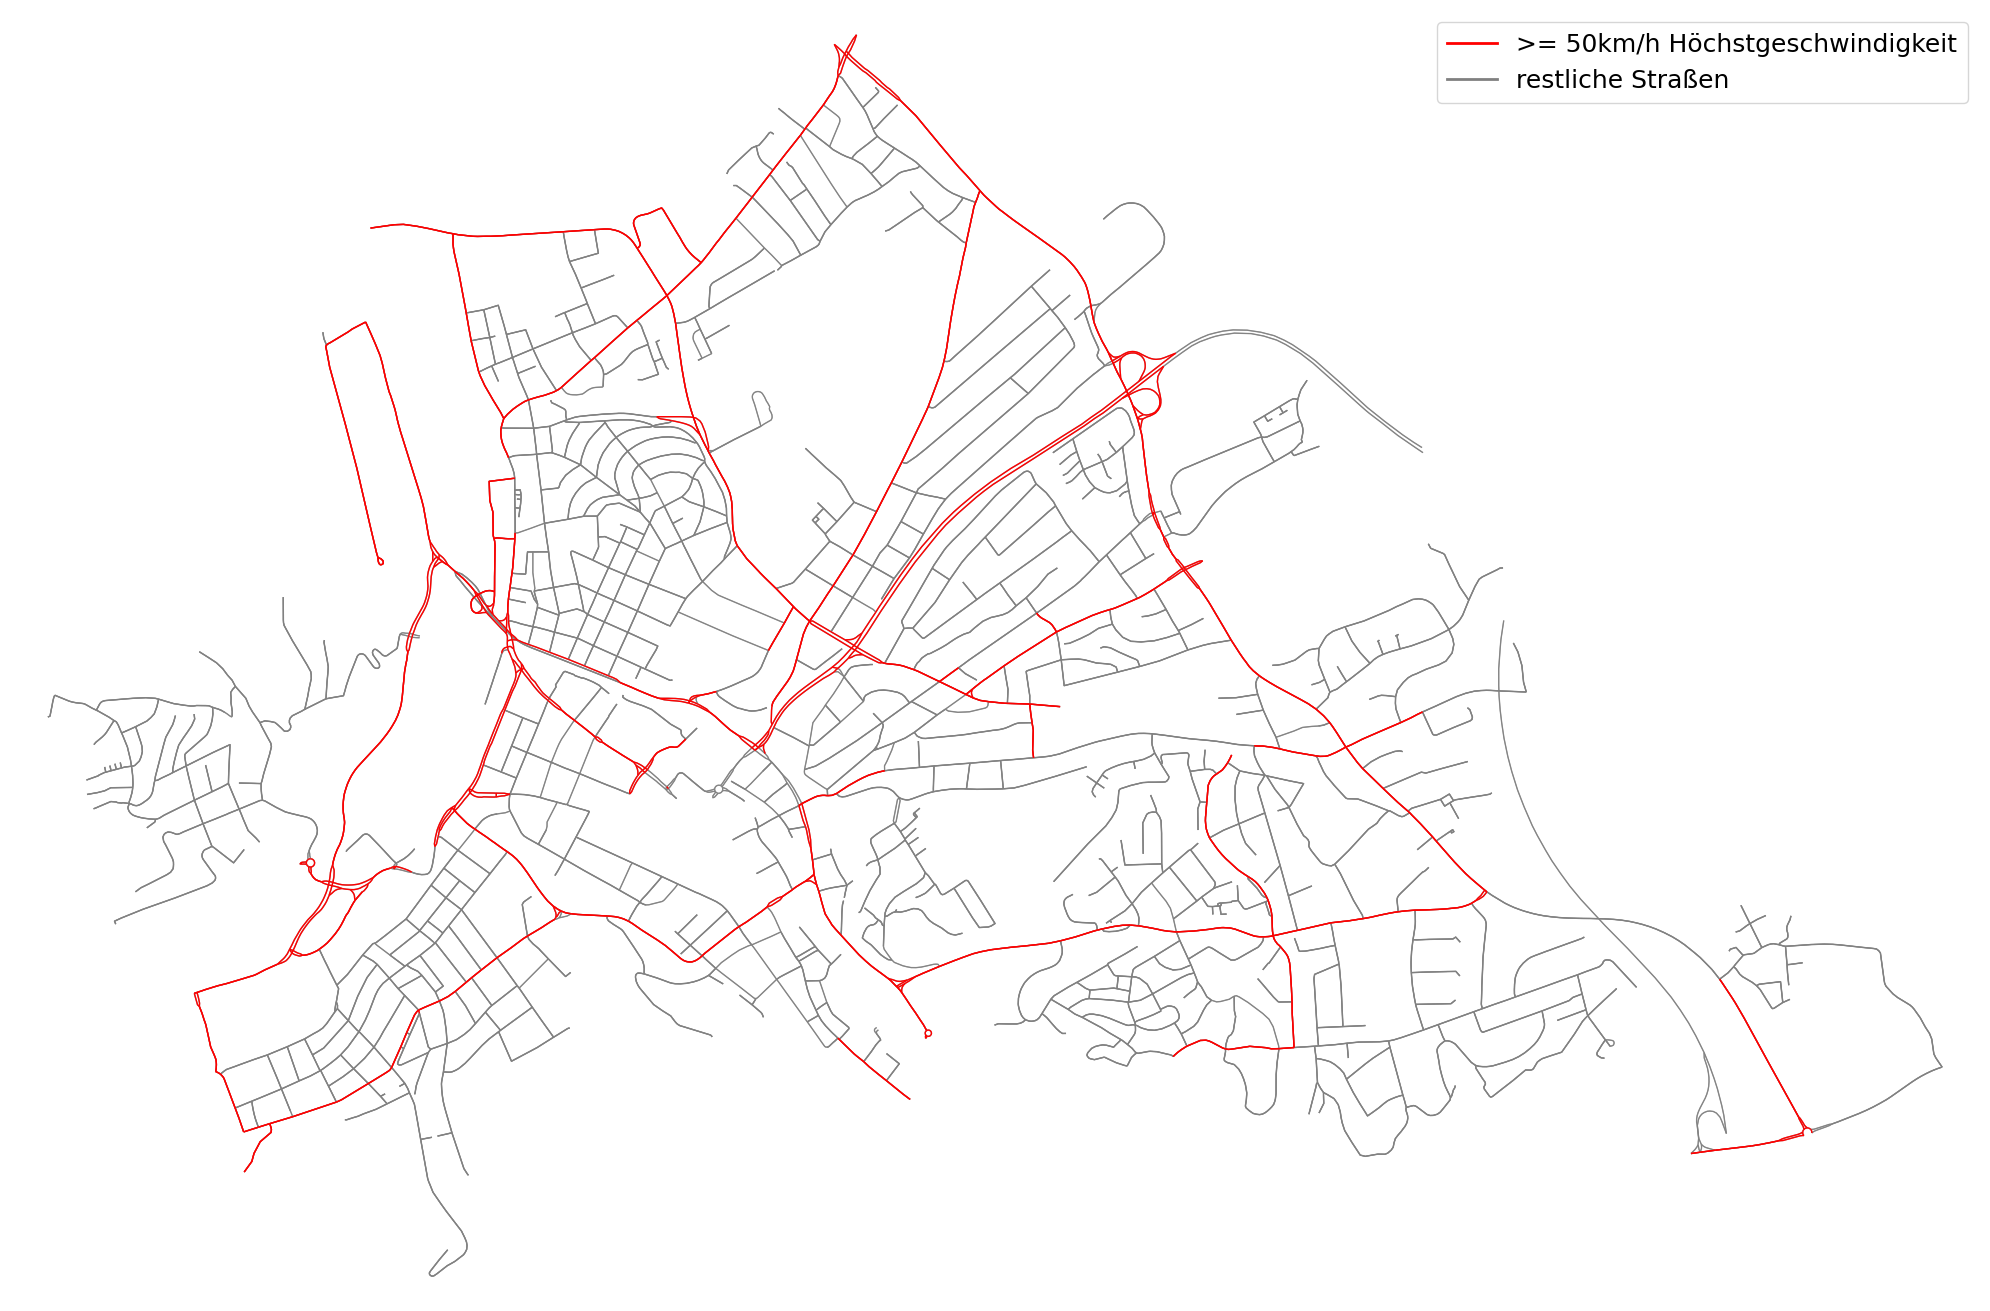

In [9]:
import re
G = ox.graph_from_place("Hagen Mitte, Germany", network_type="drive")
# Extrahiere alle Kanten aus Graph B
all_nodes, all_edges = ox.graph_to_gdfs(G)

# Muster für die Filterung
pattern_maxspeed = re.compile(r"^(50|60|70|80)$")
pattern_highway = re.compile(r"trunk|trunk_link")

# Filtermaske: maxspeed in (50, 60, 70, 80) ODER highway ist trunk/trunk_link
mask = all_edges["maxspeed"].astype(str).str.match(pattern_maxspeed) | all_edges["highway"].astype(str).str.contains(pattern_highway)

# Gefilterte "schnelle" Kanten
fast_edges_filtered = all_edges[mask]

# Zeichne das Netz
fig, ax = ox.plot_graph(G, node_color='none', show=False, close=False, figsize=(20,20), dpi=300)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Zeichne die Kanten nach Kategorie
fast_edges_filtered.plot(ax=ax, color='red', linewidth=1, alpha=1, zorder=4)

# Die restlichen Kanten (ohne slow, bike, fast)
remaining_edges = all_edges[~all_edges.index.isin(fast_edges_filtered.index)]
remaining_edges.plot(ax=ax, color='grey', linewidth=0.7, alpha=0.9)

# Legende
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='>= 50km/h Höchstgeschwindigkeit'),
    Line2D([0], [0], color='grey', lw=2, label='restliche Straßen')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=18)

plt.tight_layout()
plt.savefig('Masterarbeit/Autonetz_schnell.png', dpi=300, bbox_inches='tight')
plt.show()


### Bike

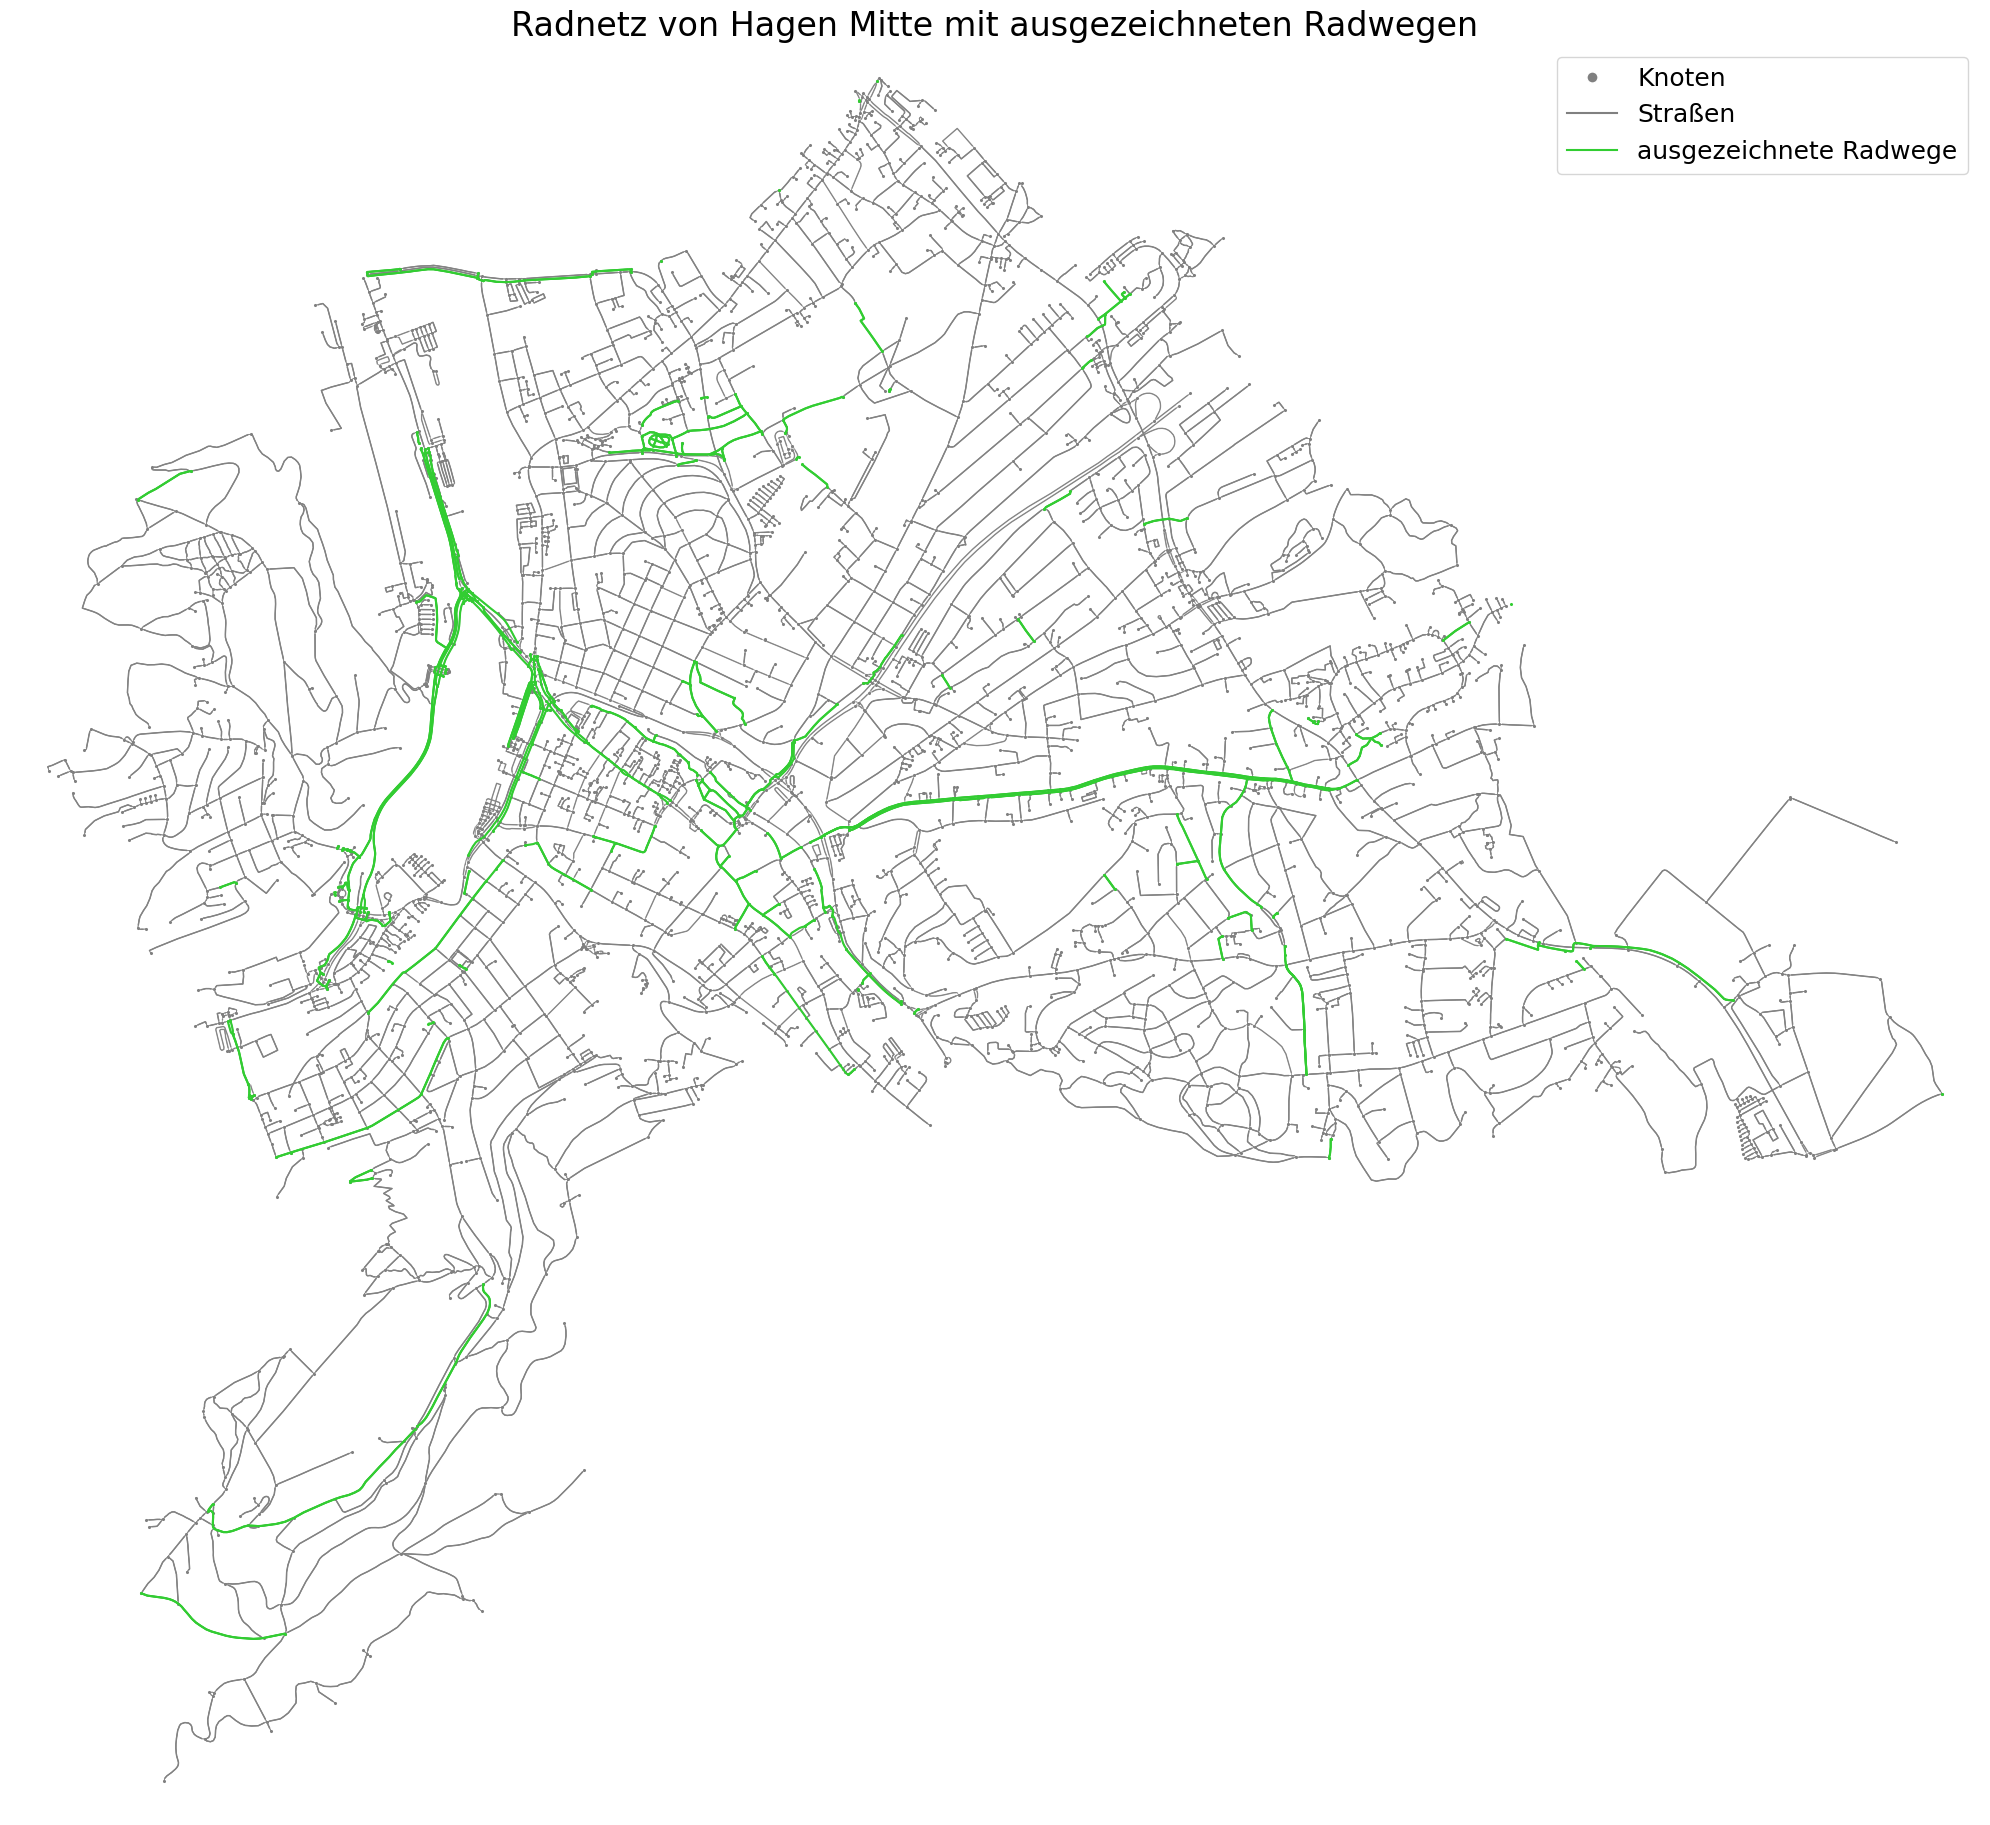

In [20]:
B = ox.graph_from_place("Hagen Mitte, Germany", network_type="bike")
nodes, edges = ox.graph_to_gdfs(B)

bike_nodes, bike_edges = ox.graph_to_gdfs(Cycleway_combined_filtered)

# Extrahieren Sie die Kanten-IDs
bike_edge_ids = bike_edges.index

# Erstellen Sie die Figur und den Achsenbereich
fig, ax = ox.plot_graph(B, show=False, close=False, figsize=(20,20), dpi=300)

fig.patch.set_facecolor('white')  # Hintergrund der gesamten Figur weiß
ax.set_facecolor('white') 

# # Zeichnen Sie die normalen Kanten
normal_edges = edges[~edges.index.isin(bike_edge_ids)]
normal_edges.plot(ax=ax, color='grey', linewidth=0.5, alpha=1)

# # Zeichnen Sie die Radwege Kanten
bike_edges.plot(ax=ax, color='#32CD32', linewidth=1.5, alpha=1, zorder=3)

# Zeichnen Sie die normalen Knoten
normal_nodes = nodes[~nodes.index.isin(bike_nodes)]
normal_nodes.plot(ax=ax, color='grey', markersize=1.5, alpha=1)

# Zeichnen Sie die Radwege Knoten größer und in einer anderen Farbe
bike_nodes.plot(ax=ax, color='#32CD32', markersize=1.5, alpha=1, zorder=3)

# Legende erstellen
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Knoten', markerfacecolor='grey', markersize=8),
    Line2D([0], [0], color='grey', lw=1.5, label='Straßen'),
    Line2D([0], [0], color='#32CD32', lw=1.5, label='ausgezeichnete Radwege')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=18)


# Titel und Achsenbeschriftungen
ax.set_title(f"Radnetz von Hagen Mitte mit ausgezeichneten Radwegen", fontsize=24)

# Layout anpassen und speichern
plt.tight_layout()
plt.savefig('Masterarbeit/Radwegenetz_im_Radnetz.png', dpi=300, bbox_inches='tight')
plt.show()


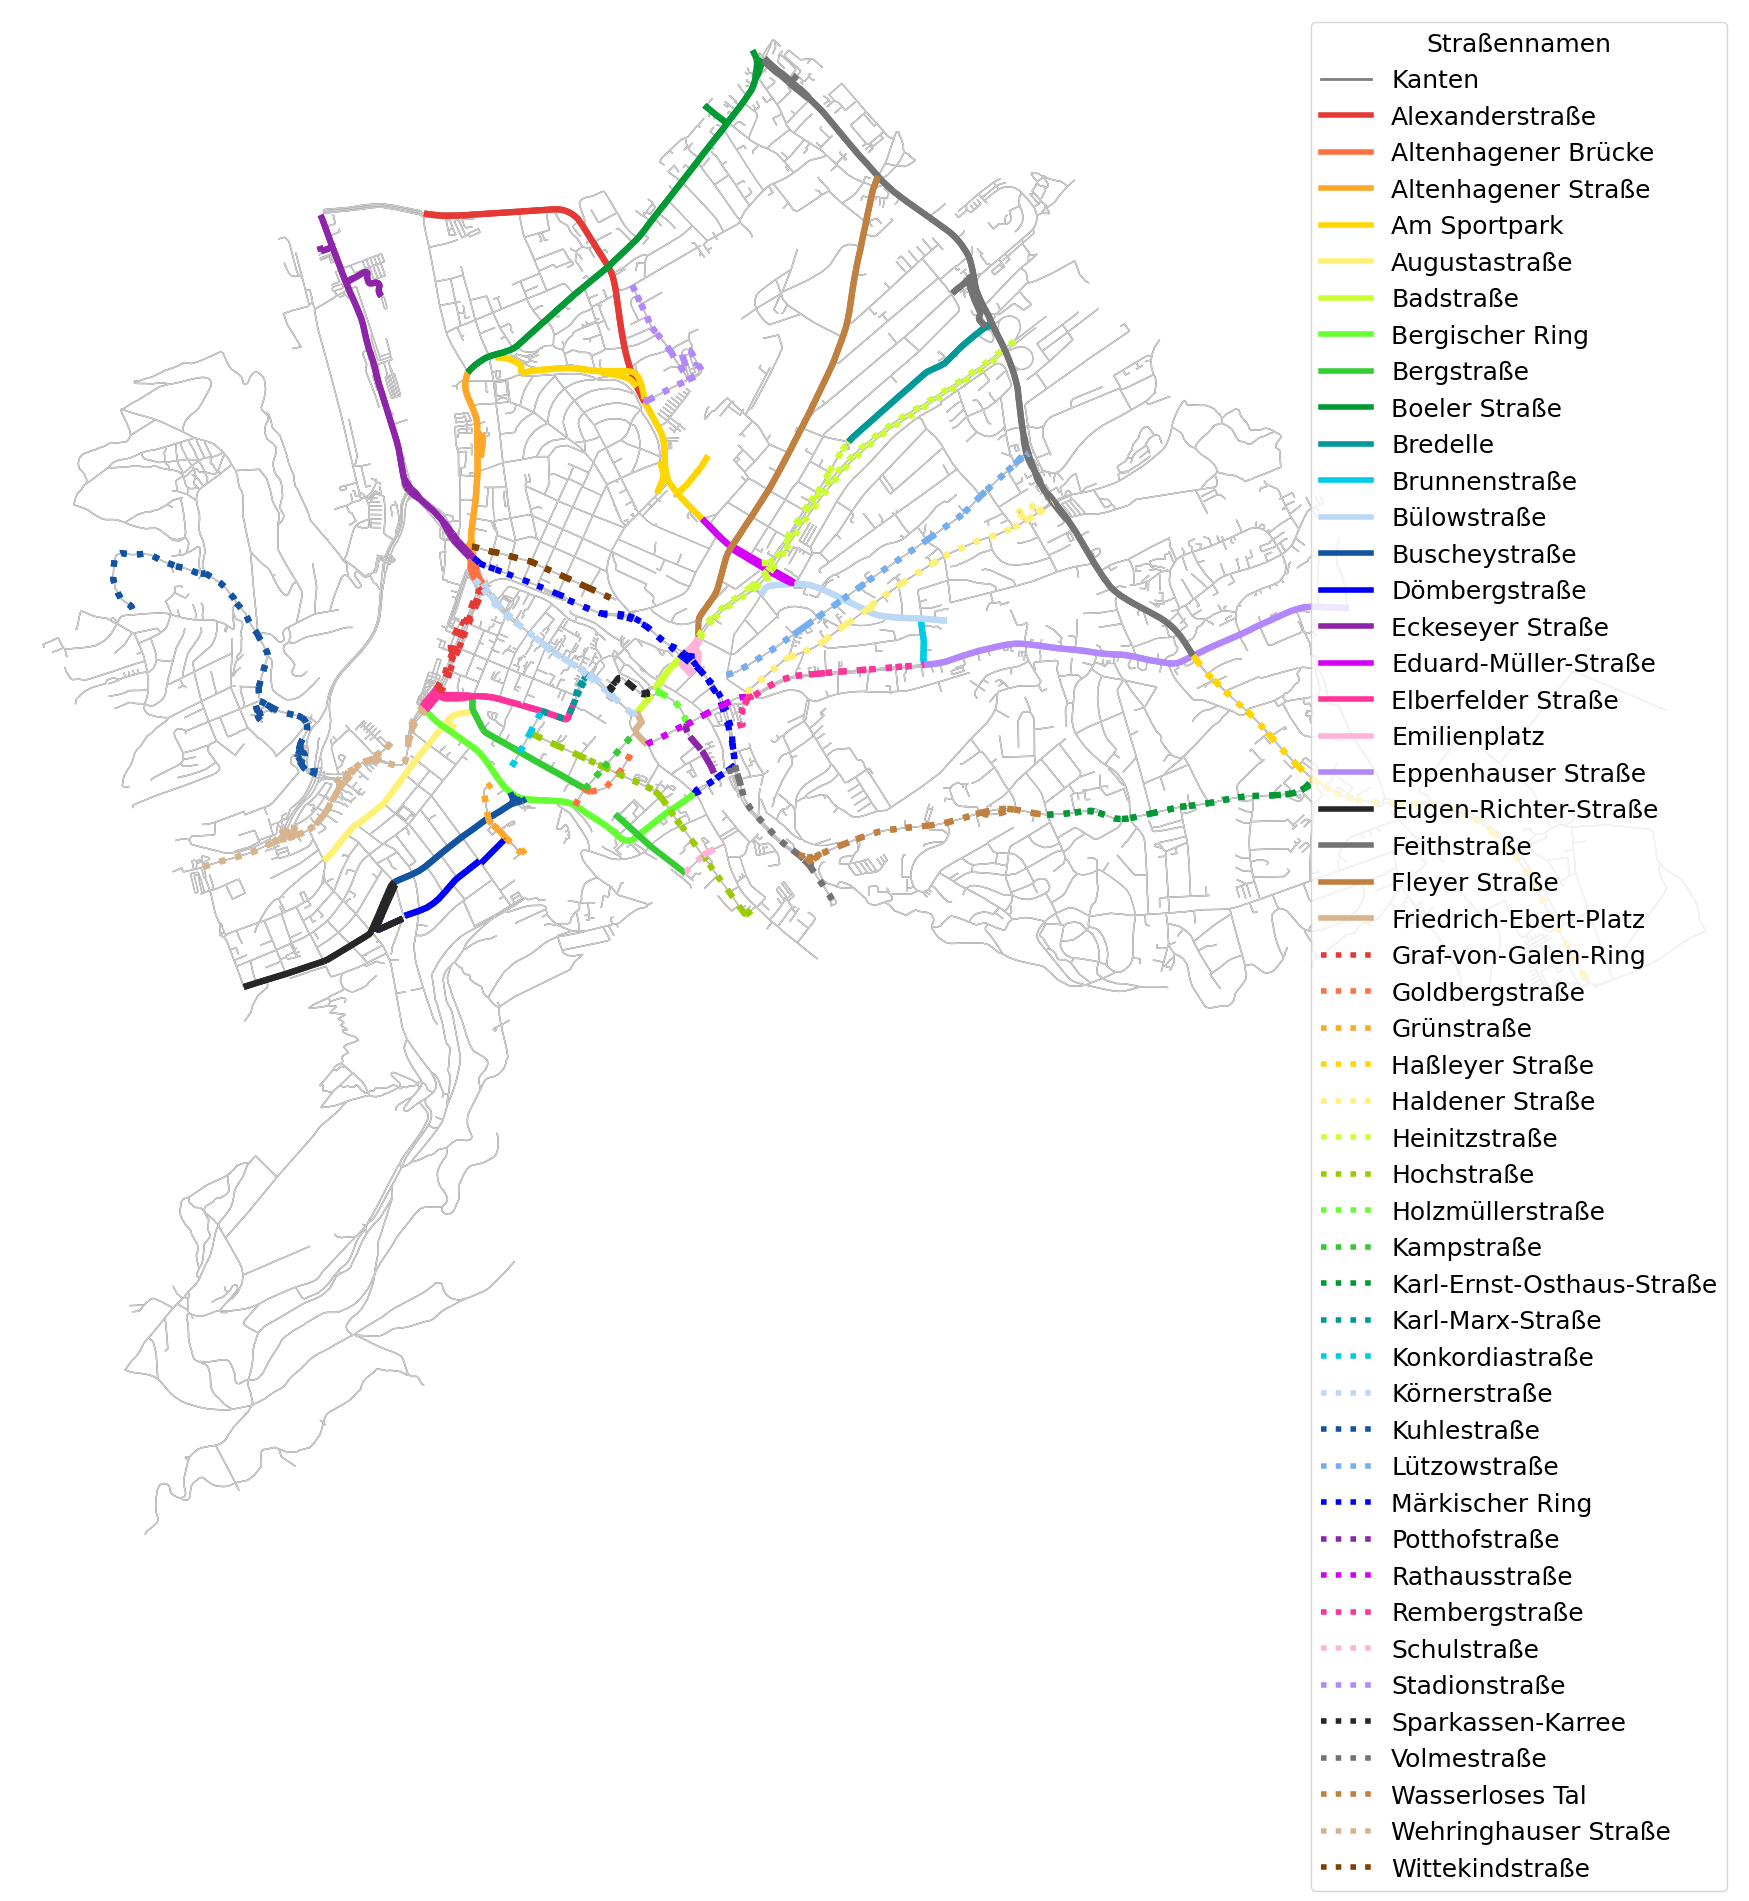

In [17]:
B = ox.graph_from_place("Hagen Mitte, Germany", network_type="bike")
nodes, edges = ox.graph_to_gdfs(B)

fig, ax = ox.plot_graph(B, node_color='none', show=False, close=False, figsize=(20,20), dpi=300)

fig.patch.set_facecolor('white')  # Hintergrund der gesamten Figur weiß
ax.set_facecolor('white') 

edges.plot(ax=ax, color='lightgrey', linewidth=0.5, alpha=1)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='grey', lw=2, label='Kanten')]

# 4.1 Spezifische Straßennamen einfärben
street_colors = {
    "Alexanderstraße": "#e53935",              # strongred
    "Altenhagener Brücke": "#ff7043",          # orangecoral
    "Altenhagener Straße": "#ffa726",          # amberorange
    "Am Sportpark": "#ffd600",                 # lemonyellow
    "Augustastraße": "#fff176",                # lightyellow
    "Badstraße": "#ccff33",                    # limegreen
    "Bergischer Ring": "#66ff33",              # springgreen
    "Bergstraße": "#33cc33",                   # grassgreen
    "Boeler Straße": "#009933",                # forestgreen
    "Bredelle": "#009999",                     # teal
    "Brunnenstraße": "#00cbe6",                # brightcyan
    "Bülowstraße": "#bbd9f7",                  # skyblue
    "Buscheystraße": "#1254a1",                # royalblue
    "Dömbergstraße": "#0000ff",                # pureblue
    "Eckeseyer Straße": "#8e24aa",             # violet
    "Eduard-Müller-Straße": "#d500f9",         # magenta
    "Elberfelder Straße": "#ff3399",           # pink
    "Emilienplatz": "#ffb3da",                 # lightpink
    "Eppenhauser Straße": "#b388ff",           # lavender
    "Eugen-Richter-Straße": "#262626",         # darkgrey
    "Feithstraße": "#737373",                  # mediumgrey
    "Fleyer Straße": "#bf8040",                # brown
    "Friedrich-Ebert-Platz": "#d9b38c"         # beige
 }

for street_name, color in street_colors.items():
    # Filterung mit Berücksichtigung von Listen in 'name'-Attributen
    mask = edges['name'].apply(
        lambda x: street_name in x if isinstance(x, list) else x == street_name
    )
    edges[mask].plot(
        ax=ax,
        color=color,
        linewidth=4.5,
        alpha=1,
        zorder=4,
        label=street_name
    )

# 4.1 Spezifische Straßennamen einfärben
street_colors2 = {  
    "Graf-von-Galen-Ring": "#e53935",         # strongred
    "Goldbergstraße": "#ff7043",              # orangecoral
    "Grünstraße": "#ffa726",                  # amberorange
    "Haßleyer Straße": "#ffd600",             # lemonyellow
    "Haldener Straße": "#fff176",             # lightyellow
    "Heinitzstraße": "#ccff33",               # limegreen
    "Hochstraße": "#99cc00",                  # darklimegreen
    "Holzmüllerstraße": "#66ff33",            # springgreen
    "Kampstraße": "#33cc33",                  # grassgreen
    "Karl-Ernst-Osthaus-Straße": "#009933",   # forestgreen
    "Karl-Marx-Straße": "#009999",            # teal
    "Konkordiastraße": "#00cbe6",             # brightcyan
    "Körnerstraße": "#bbd9f7",                # skyblue
    "Kuhlestraße": "#1254a1",                 # royalblue
    "Lützowstraße": "#75aef0",                # lightroyalblue
    "Märkischer Ring": "#0000ff",             # pureblue
    "Potthofstraße": "#8e24aa",               # violet
    "Rathausstraße": "#d500f9",               # magenta
    "Rembergstraße": "#ff3399",               # pink
    "Schulstraße": "#ffb3da",                 # lightpink
    "Stadionstraße": "#b388ff",               # lavender
    "Sparkassen-Karree": "#262626",           # darkgrey
    "Volmestraße": "#737373",                 # mediumgrey
    "Wasserloses Tal": "#bf8040",             # brown
    "Wehringhauser Straße": "#d9b38c",        # beige
    "Wittekindstraße": "#804000"              # darkbrown

}


for street_name, color in street_colors2.items():
    # Filterung mit Berücksichtigung von Listen in 'name'-Attributen
    mask = edges['name'].apply(
        lambda x: street_name in x if isinstance(x, list) else x == street_name
    )
    edges[mask].plot(
        ax=ax,
        color=color,
        linewidth=4.5,
        alpha=1,
        zorder=4,
        label=street_name,
        linestyle=':'
    )
    
# Straßennamen zur Legende hinzufügen
legend_elements.extend([
    Line2D([0], [0], color=color, lw=4, label=name) 
    for name, color in street_colors.items()
])

legend_elements.extend([
    Line2D([0], [0], color=color, lw=4, label=name, linestyle=':') 
    for name, color in street_colors2.items()
])


ax.legend(
    handles=legend_elements,
    title=f"Straßennamen",
    loc='upper right',
    fontsize=18,
    title_fontsize=18
)

plt.tight_layout()
plt.savefig('Masterarbeit/Radnetz_Straßennamen3.png', dpi=300, bbox_inches='tight')
plt.show()

#### Bike Stress colorcoded

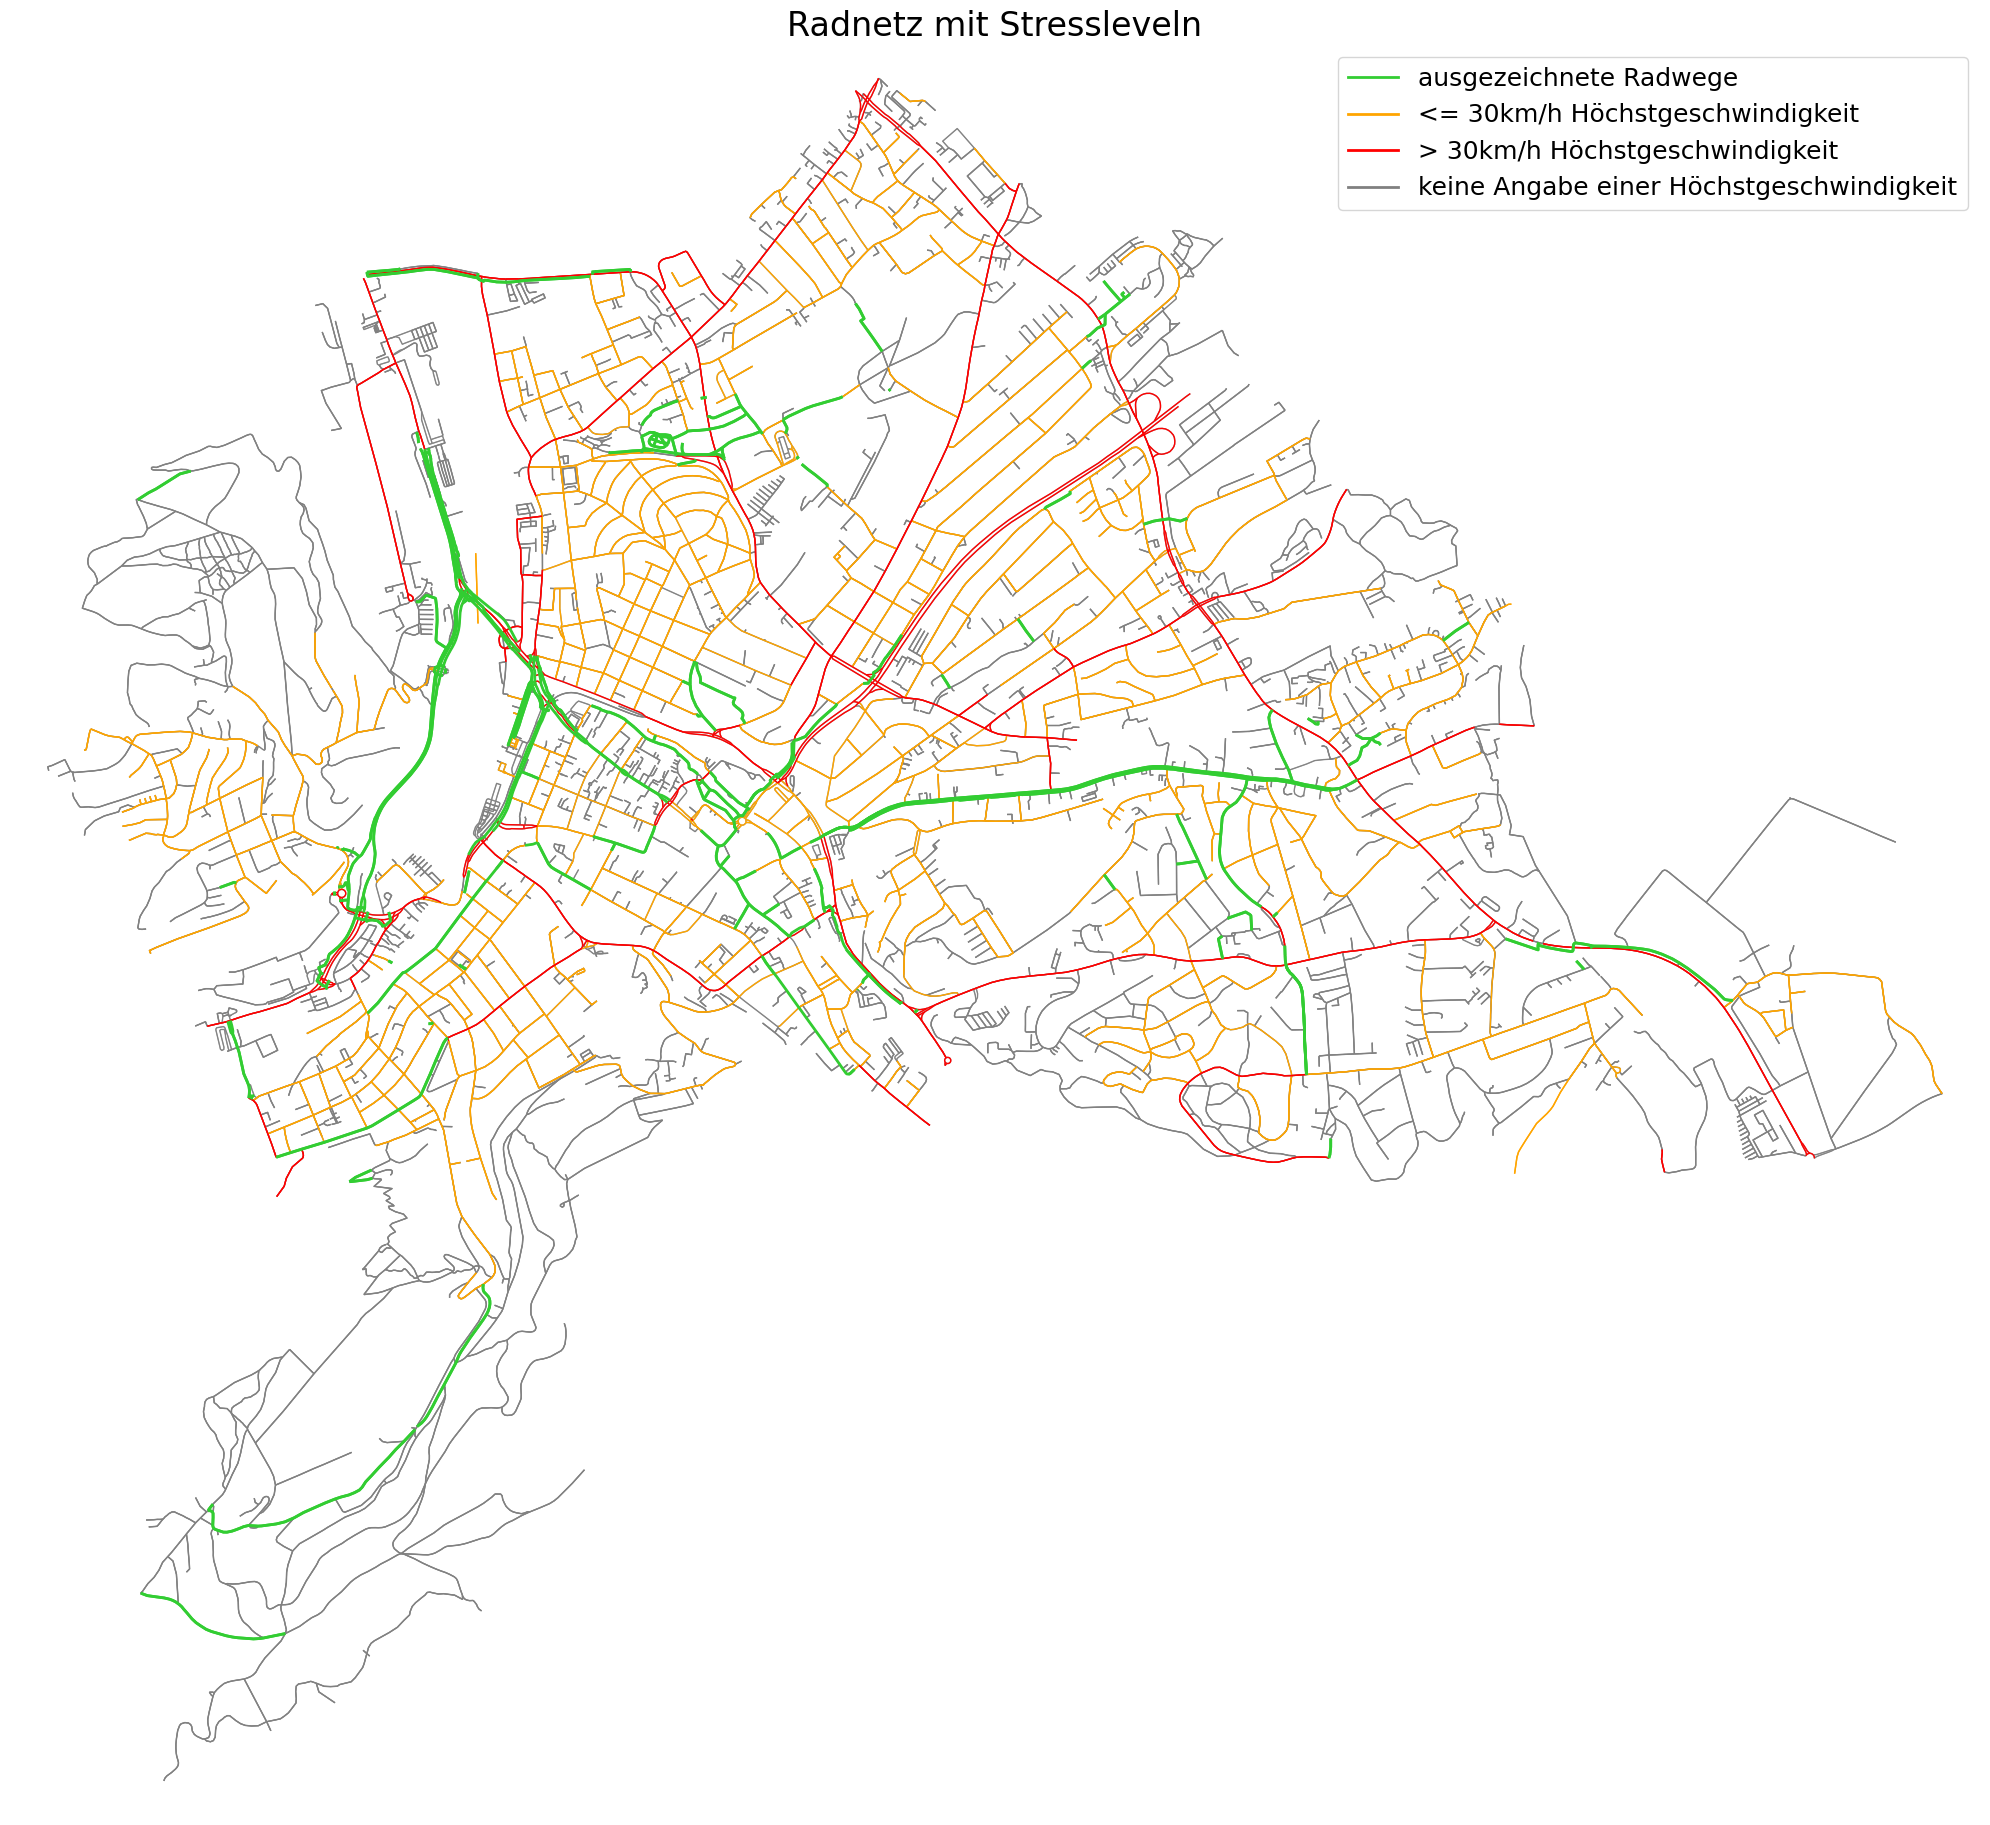

In [30]:
import re

# Extrahiere alle Kanten aus Graph B
all_nodes, all_edges = ox.graph_to_gdfs(B)

# Muster für die Filterung
pattern_maxspeed = re.compile(r"^(40|50|60|70|80)$")
pattern_highway = re.compile(r"trunk|trunk_link")

# Filtermaske: maxspeed in (40, 50, 60, 70, 80) ODER highway ist trunk/trunk_link
mask = all_edges["maxspeed"].astype(str).str.match(pattern_maxspeed) | all_edges["highway"].astype(str).str.contains(pattern_highway)

# Gefilterte "schnelle" Kanten
fast_edges_filtered = all_edges[mask]

# Extrahiere IDs der langsamen und Fahrrad-Kanten
slow_nodes, slow_edges = ox.graph_to_gdfs(G_slow)
bike_nodes, bike_edges = ox.graph_to_gdfs(Cycleway_combined_filtered)
slow_edge_ids = slow_edges.index
bike_edge_ids = bike_edges.index

# Zeichne das Netz
fig, ax = ox.plot_graph(B, node_color='none', show=False, close=False, figsize=(20,20), dpi=300)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Zeichne die Kanten nach Kategorie
slow_edges.plot(ax=ax, color='orange', linewidth=1, alpha=1, zorder=3)
fast_edges_filtered.plot(ax=ax, color='red', linewidth=1, alpha=1, zorder=4)

# Die restlichen Kanten (ohne slow, bike, fast)
remaining_edges = all_edges[
    ~all_edges.index.isin(slow_edge_ids)
    & ~all_edges.index.isin(bike_edge_ids)
    & ~all_edges.index.isin(fast_edges_filtered.index)
]
remaining_edges.plot(ax=ax, color='grey', linewidth=0.7, alpha=0.9)

# Radwege-Kanten grün
bike_edges.plot(ax=ax, color='#32CD32', linewidth=2, alpha=1, zorder=5)

# Legende
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='#32CD32', lw=2, label='ausgezeichnete Radwege'),
    Line2D([0], [0], color='orange', lw=2, label='<= 30km/h Höchstgeschwindigkeit'),
    Line2D([0], [0], color='red', lw=2, label='> 30km/h Höchstgeschwindigkeit'),
    Line2D([0], [0], color='grey', lw=2, label='keine Angabe einer Höchstgeschwindigkeit')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=18)

ax.set_title("Radnetz mit Stressleveln", fontsize=24)

plt.tight_layout()
plt.savefig('Masterarbeit/Radnetz_Stresslevel.png', dpi=300, bbox_inches='tight')
plt.show()


### Cycleway_combined

#### Komponenten

In [25]:
# Schwache Zusammenhangskomponenten identifizieren
components = list(nx.weakly_connected_components(Cycleway_combined_filtered))

# Komponenten nach Größe sortieren
components_sorted = sorted(components, key=len, reverse=True)

# Die vier größten Komponenten extrahieren und als separate Graphen speichern
one = Cycleway_combined.subgraph(components_sorted[0]).copy()
two = Cycleway_combined.subgraph(components_sorted[1]).copy()
three = Cycleway_combined.subgraph(components_sorted[2]).copy()
four = Cycleway_combined.subgraph(components_sorted[3]).copy()
five = Cycleway_combined.subgraph(components_sorted[4]).copy()
six = Cycleway_combined.subgraph(components_sorted[5]).copy()
seven = Cycleway_combined.subgraph(components_sorted[6]).copy()

# Konvertiere die Subgraphen zu GeoDataFrames
one_nodes, one_edges = ox.graph_to_gdfs(one)
two_nodes, two_edges = ox.graph_to_gdfs(two)
three_nodes, three_edges = ox.graph_to_gdfs(three)
four_nodes, four_edges = ox.graph_to_gdfs(four)
five_nodes, five_edges = ox.graph_to_gdfs(five)
six_nodes, six_edges = ox.graph_to_gdfs(six)
seven_nodes, seven_edges = ox.graph_to_gdfs(seven)


# Restliche Komponenten in einem separaten Graph zusammenfassen (optional)
remaining_nodes = set(Cycleway_combined_filtered.nodes) - set.union(components_sorted[0], components_sorted[1], components_sorted[2], components_sorted[3], components_sorted[4], components_sorted[5], components_sorted[6])
remaining_graph = Cycleway_combined_filtered.subgraph(remaining_nodes).copy()
remaining_nodes_gdf, remaining_edges_gdf = ox.graph_to_gdfs(remaining_graph)

# Beispiel: Ausgabe der Größen der Subgraphen
print(f"Subgraph one: {len(one_nodes)} Knoten, {len(one_edges)} Kanten")
print(f"Subgraph two: {len(two_nodes)} Knoten, {len(two_edges)} Kanten")
print(f"Subgraph three: {len(three_nodes)} Knoten, {len(three_edges)} Kanten")
print(f"Subgraph four: {len(four_nodes)} Knoten, {len(four_edges)} Kanten")
print(f"Subgraph five: {len(five_nodes)} Knoten, {len(five_edges)} Kanten")
print(f"Subgraph six: {len(six_nodes)} Knoten, {len(six_edges)} Kanten")
print(f"Subgraph seven: {len(seven_nodes)} Knoten, {len(seven_edges)} Kanten")



Subgraph one: 58 Knoten, 99 Kanten
Subgraph two: 28 Knoten, 58 Kanten
Subgraph three: 17 Knoten, 38 Kanten
Subgraph four: 10 Knoten, 12 Kanten
Subgraph five: 10 Knoten, 12 Kanten
Subgraph six: 8 Knoten, 14 Kanten
Subgraph seven: 8 Knoten, 24 Kanten


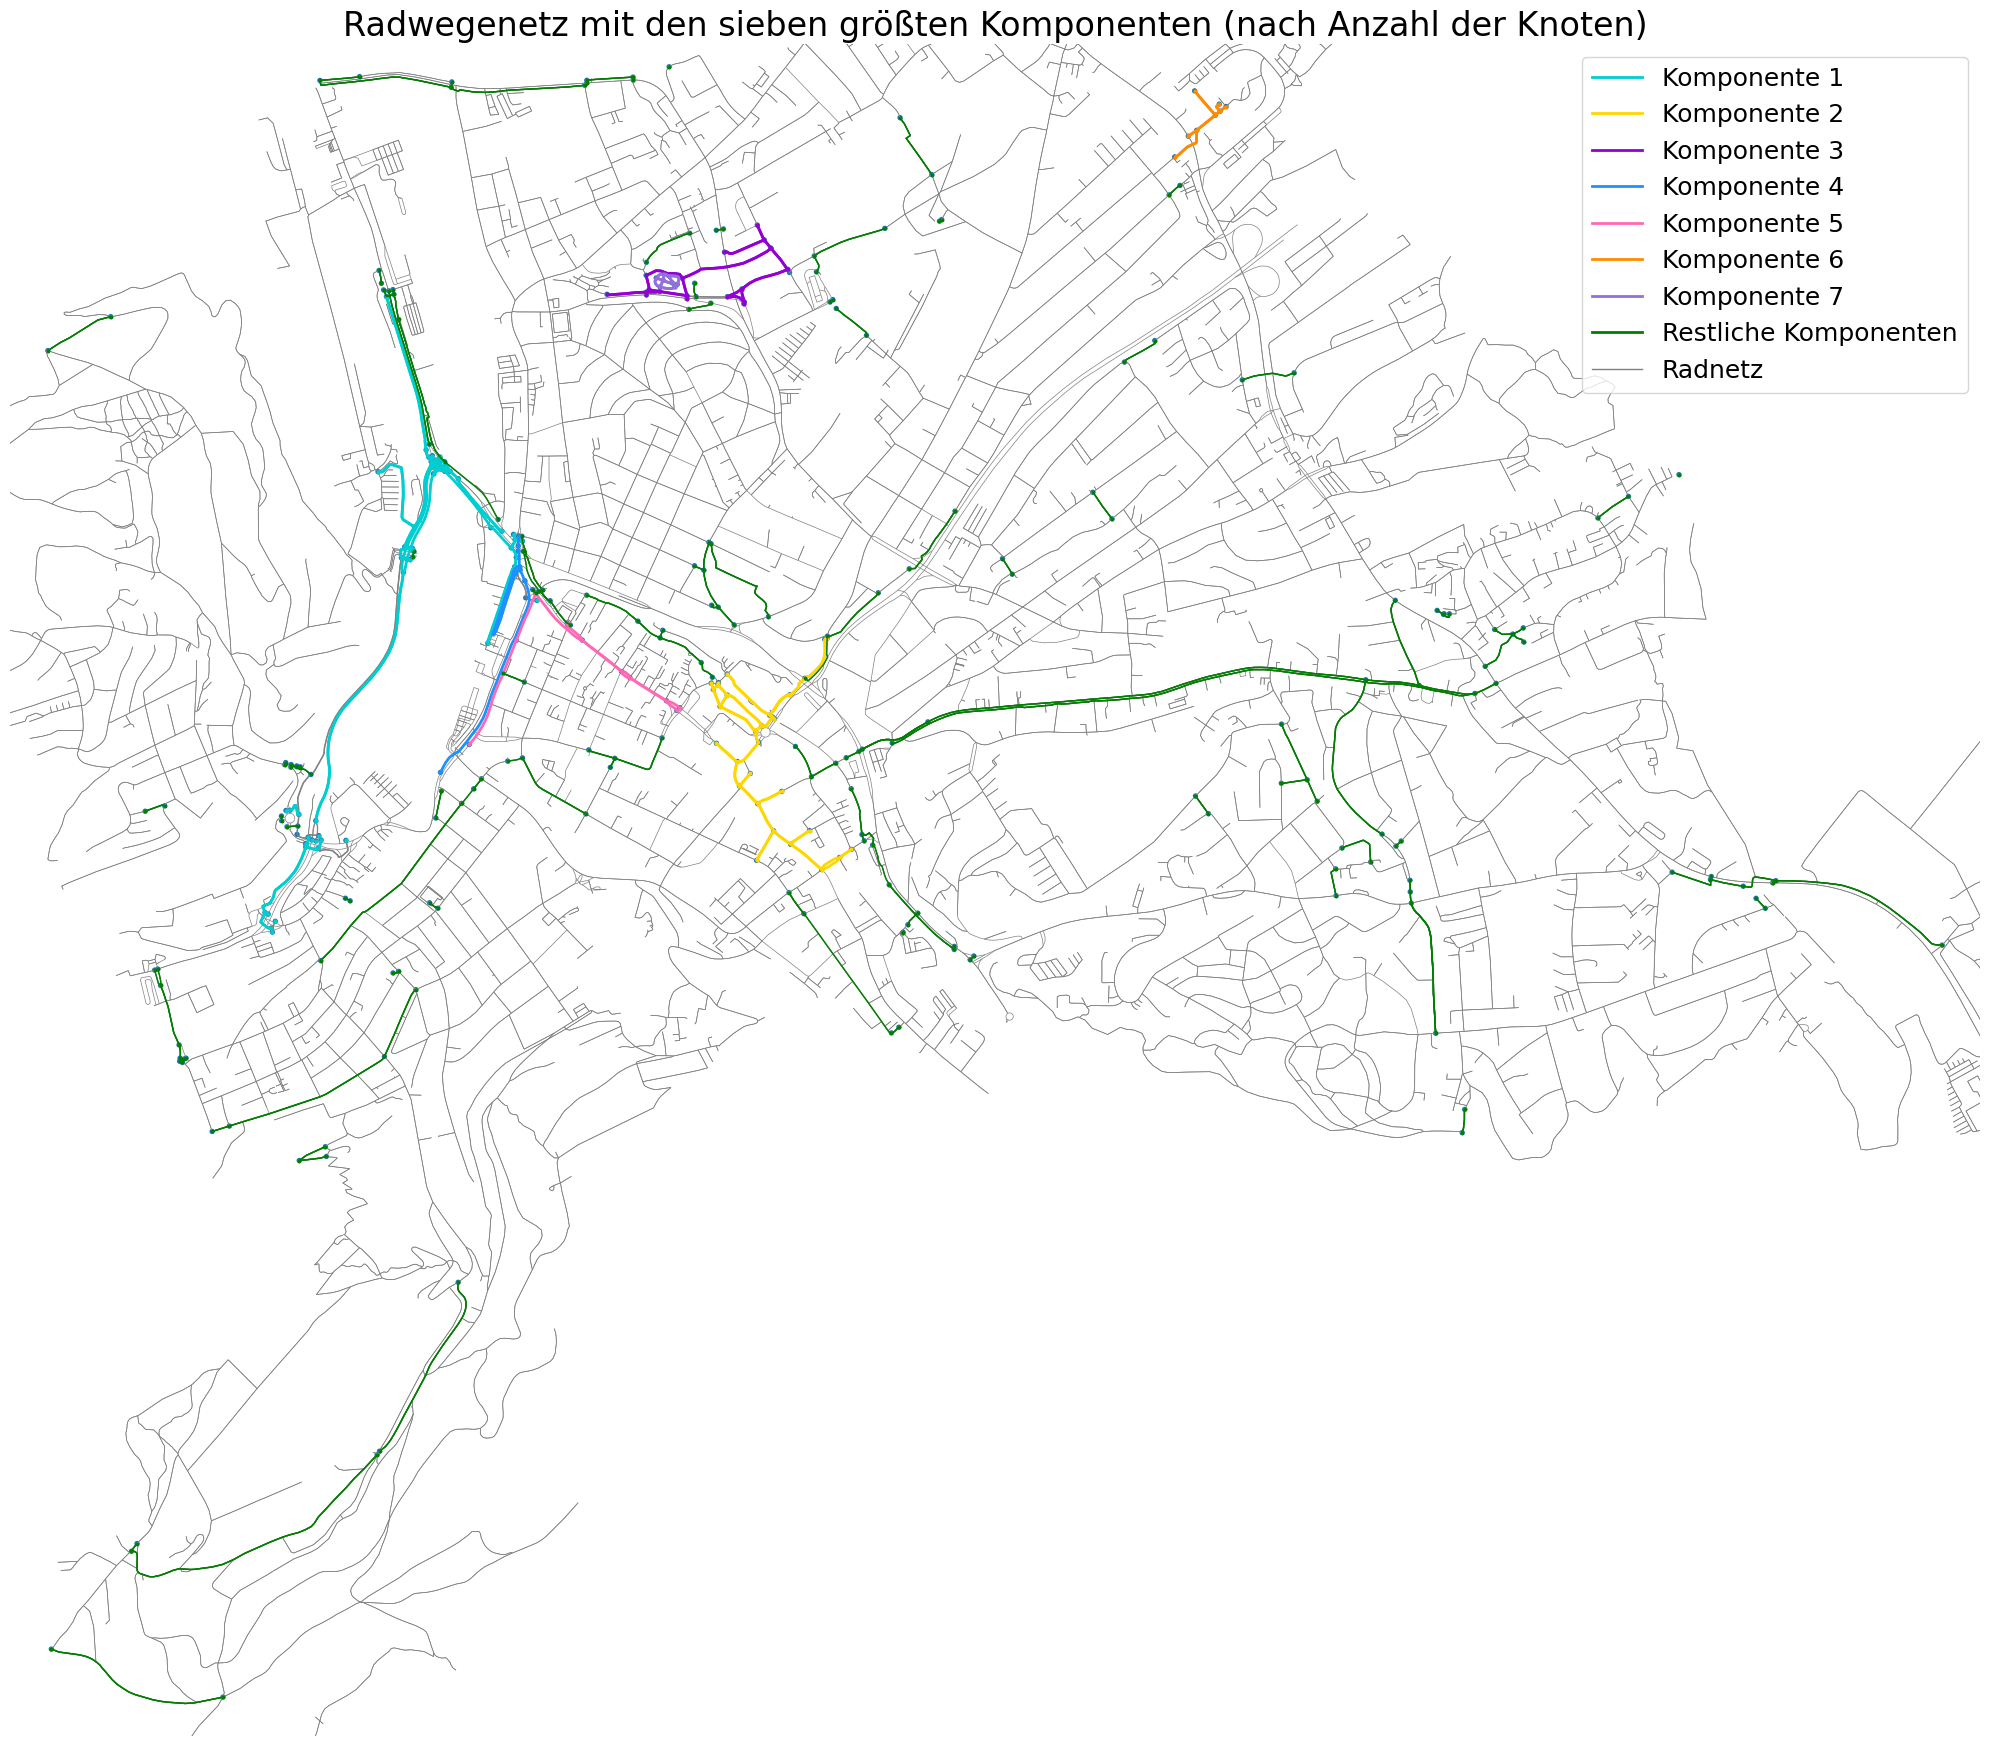

In [27]:
# Erstellen Sie die Figur und den Achsenbereich
fig, ax = ox.plot_graph(Cycleway_combined_filtered, node_color = None, show=False, close=False, figsize=(20,20), dpi=300)

nodes, edges = ox.graph_to_gdfs(Cycleway_combined_filtered)

bike_nodes, bike_edges = ox.graph_to_gdfs(B)

fig.patch.set_facecolor('white')  # Hintergrund der gesamten Figur weiß
ax.set_facecolor('white') 

# Definieren Sie die Farben für die Komponenten
colors = {
    'one': '#00CED1',      # Türkis (leuchtend, klar)
    'two': '#FFD700',      # Goldgelb (satt, warm)
    'three': '#9400D3',    # Dunkelviolett (tiefes Lila)
    'four': '#1E90FF',     # Dodger-Blau (kräftig, leuchtend)
    'five': '#FF69B4',     # Pink (lebendig, kräftig)
    'six': '#FF8C00',      # Dunkles Orange (kräftig, bernsteinfern)
    'seven': '#9370DB',    # Hell-Lila (dezent, blaustichig)
    'remaining': '#008000' # Grün (für Kanten)
}

# Zeichnen Sie die Kanten und Knoten für jede Komponente
for name, edges, nodes in [
    ('one', one_edges, one_nodes),
    ('two', two_edges, two_nodes),
    ('three', three_edges, three_nodes),
    ('four', four_edges, four_nodes),
    ('five', five_edges, five_nodes),
    ('six', six_edges, six_nodes),
    ('seven', seven_edges, seven_nodes),
    ('remaining', remaining_edges_gdf, remaining_nodes_gdf)
]:
    color = colors[name]
    edges.plot(ax=ax, color=color, linewidth=2 if name != 'remaining' else 1, alpha=1 if name != 'remaining' else 1, zorder=3)
    nodes.plot(ax=ax, color=color, markersize=4 if name != 'remaining' else 3, alpha=1 if name != 'remaining' else 1, zorder=3)

    
    
bike_edges.plot(ax=ax, color='grey', linewidth=0.5, alpha=1)

# Legende erstellen
legend_elements = [
    Line2D([0], [0], color='#00CED1', lw=2, label='Komponente 1'),  # Türkis
    Line2D([0], [0], color='#FFD700', lw=2, label='Komponente 2'),  # Goldgelb
    Line2D([0], [0], color='#9400D3', lw=2, label='Komponente 3'),  # Dunkelviolett
    Line2D([0], [0], color='#1E90FF', lw=2, label='Komponente 4'),  # Dodger-Blau
    Line2D([0], [0], color='#FF69B4', lw=2, label='Komponente 5'),  # Pink
    Line2D([0], [0], color='#FF8C00', lw=2, label='Komponente 6'),  # Dunkles Orange
    Line2D([0], [0], color='#9370DB', lw=2, label='Komponente 7'),  # Hell-Lila
    Line2D([0], [0], color='green', lw=2, label='Restliche Komponenten'),  # Grün (Kanten)
    Line2D([0], [0], color='grey', lw=1, label='Radnetz')
]

ax.legend(handles=legend_elements, loc='upper right', fontsize=18)

# Titel und Achsenbeschriftungen
ax.set_title("Radwegenetz mit den sieben größten Komponenten (nach Anzahl der Knoten)", fontsize=24)

# Layout anpassen und speichern
plt.tight_layout()
plt.savefig('Masterarbeit/Cycleway_combined_Komponenten.png', dpi=300, bbox_inches='tight')
plt.show()
